In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import log_loss

In [ ]:
def sigmoid(z):
    return 1.0/(1.0+ np.exp(-z))

In [ ]:
def sigmoid_prime(z):
  return sigmoid(z)*(1.0-sigmoid(z))

In [ ]:
def cross_entropy(weights,bias,X_train,y_train):
  return log_loss(y_train,[feedforward(X_train[k],bias,weights).reshape(-1,) for k in range(len(X_train))],labels=[1.0,0.0])

In [ ]:
def feedforward(x,bias,weights):
    for b,w in zip(bias,weights):
      x=sigmoid(np.dot(w,x)+b)
    return x

In [ ]:
def update_mini_batch(weights,bias,X_mini,y_mini,eta):
    derivative_b=[np.zeros(b.shape) for b in bias]
    derivative_w=[np.zeros(w.shape) for w in weights]
    for i in range(len(y_mini)):
      x_mi=X_mini[i]
      y_mi=y_mini[i]
      derivative_b_sample, derivative_w_sample=backprop(weights,bias,x_mi,y_mi)
      for j in range(len(derivative_b)):
        derivative_b[j]+=derivative_b_sample[j]
        derivative_w[j]+=derivative_w_sample[j]
    for i in range(len(weights)):
        weights[i]-=(eta/len(y_mini))*derivative_w[i]
        bias[i]-=(eta/len(y_mini))*derivative_b[i]
    return (weights,bias)

In [ ]:
def append_metrics(result, y_train, y_test, pred_train, pred_test, weights, bias, X_train, X_test):
    result["accuracy_train"].append(accuracy(y_train, pred_train))
    result["accuracy_test"].append(accuracy(y_test, pred_test))
    result["precision_train"].append(precision(y_train, pred_train))
    result["precision_test"].append(precision(y_test, pred_test))
    result["recall_train"].append(recall(y_train, pred_train))
    result["recall_test"].append(recall(y_test, pred_test))
    result["cross_entropy_train"].append(cross_entropy(weights, bias, X_train, y_train))
    result["cross_entropy_test"].append(cross_entropy(weights, bias, X_test, y_test))

In [ ]:
def print_metrics_table(result,i):
    print("\n \n Epoch\tTrain Precision\tTest Precision\tTrain Recall\tTest Recall\tTrain Accuracy\tTest Accuracy\tloss train\tloss test\tclass1 accuracy train\tclass0 accuracy train\tclass1 accuracy test\tclass0 accuracy test")
    print(f"{i + 1}\t{result['precision_train'][i]:.4f}\t\t{result['precision_test'][i]:.4f}\t\t{result['recall_train'][i]:.4f}\t\t{result['recall_test'][i]:.4f}\t\t{result['accuracy_train'][i][0]:.4f}\t\t{result['accuracy_test'][i][0]:.4f}\t\t{result['cross_entropy_train'][i]:.4f}\t\t{result['cross_entropy_test'][i]:.4f},\t\t\t{result['accuracy_train'][i][1]:.4f}\t\t\t{result['accuracy_train'][i][2]:.4f}\t\t\t{result['accuracy_test'][i][1]:.4f}\t\t\t{result['accuracy_test'][i][2]:.4f}")


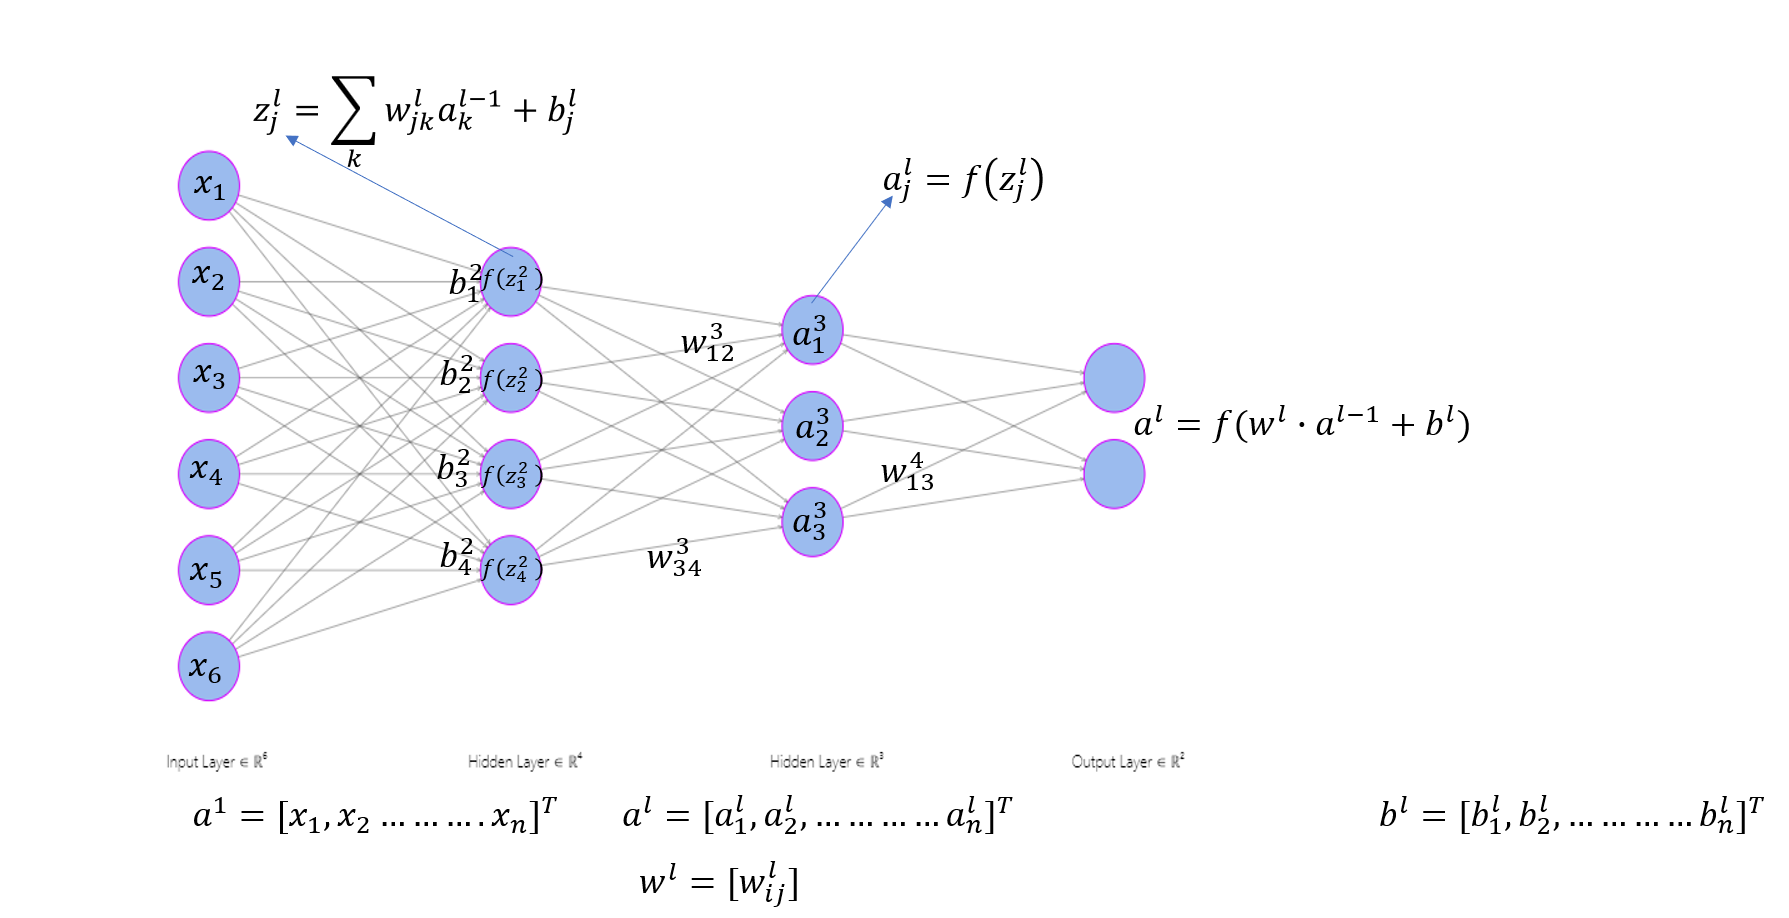

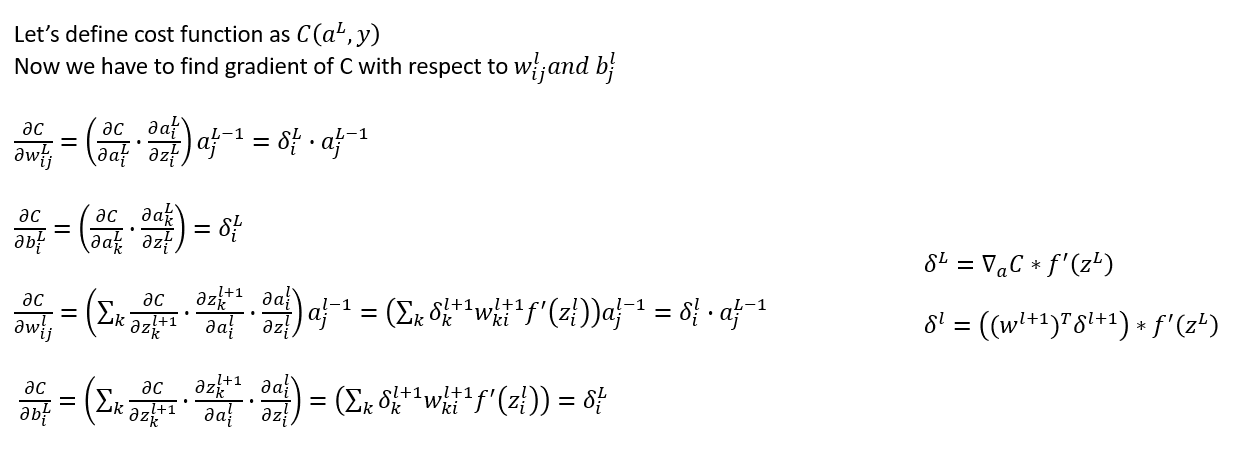

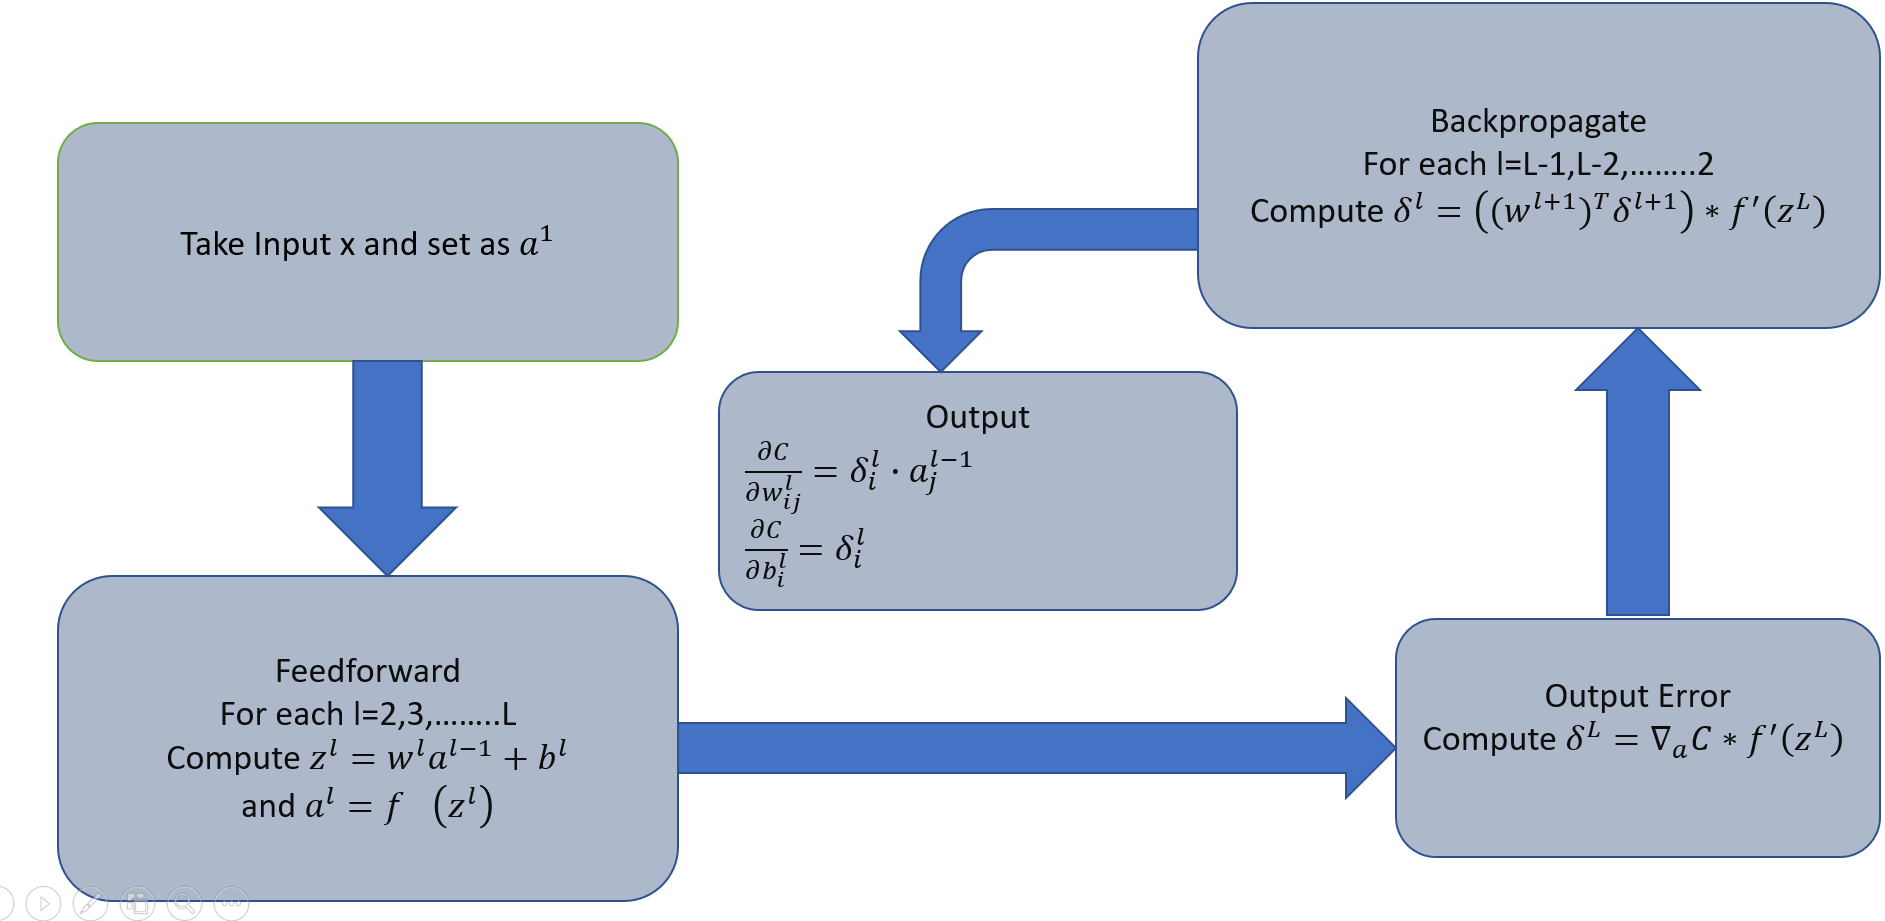

In [ ]:
def backprop(weights,bias,x,y):
    derivative_b=[np.zeros(b.shape) for b in bias]
    derivative_w=[np.zeros(w.shape) for w in weights]
    activations=[x]
    zs=[]
    i=0
    for b,w in zip(bias,weights):
      i+=1
      z=np.dot(w,activations[-1])+b
      zs.append(z)
      activations.append(sigmoid(z))
    delta = (activations[-1]-y)
    derivative_b[-1] = delta
    derivative_w[-1] = np.dot(delta,activations[-2].transpose())
    for l in range(2,len(weights)+1):
      z = zs[-l]
      sp = sigmoid_prime(z)
      delta = np.dot(weights[-l+1].transpose(),delta)*sp
      derivative_b[-l] = delta
      derivative_w[-l] = np.dot(delta,activations[-l-1].transpose())
    return (derivative_b , derivative_w)

In [ ]:
def predict(weights,bias,X_test):
    test_results = [1 if feedforward(x,bias,weights)>0.5 else 0 for x in X_test]
    return np.array(test_results)

In [ ]:
def accuracy(y_true,y_pred):
  class1_acc = np.sum((y_pred == 1.0) & (y_true == 1.0))/(sum(y_true==1.0)+1e-10)
  class0_acc = np.sum((y_pred == 0.0) & (y_true == 0.0))/(sum(y_true==0.0)+1e-10)
  return sum(y_true==y_pred)/len(y_true),class1_acc,class0_acc

In [ ]:
np.random.seed(42)

In [ ]:
def precision(predicted, true_labels):
    true_positives = np.sum((predicted == 1.0) & (true_labels == 1.0))
    false_positives = np.sum((predicted == 1.0) & (true_labels == 0.0))
    return true_positives / (true_positives + false_positives+1e-10)

In [ ]:
def recall(predicted, true_labels):
    true_positives = np.sum((predicted == 1.0) & (true_labels == 1.0))
    false_negatives = np.sum((predicted == 0.0) & (true_labels == 1.0))
    return true_positives / (true_positives + false_negatives+1e-10)

In [ ]:
def MLP(X_train,y_train,X_test,y_test,sizes,epoch,mini_batch_size,eta,flag):
    num_layers=len(sizes)
    result={"accuracy_train":[],"accuracy_test":[],"precision_train":[],"precision_test":[],"recall_train":[],"recall_test":[],"cross_entropy_train":[],"cross_entropy_test":[]}
    bias=[np.random.normal(0,np.sqrt(2.0/b),(b,1)) for b in sizes[1:]]
    weights=[np.random.normal(0,np.sqrt(2.0)/np.sqrt(a+b),(a,b)) for a,b in zip(sizes[1:],sizes[:-1])]
    n_test=len(y_test)
    n=len(y_train)
    for i in tqdm(range(epoch)):
      idx = np.random.permutation(len(y_train))
      x,y = X_train[idx], y_train[idx]
      for j in range(0,n,mini_batch_size):
        weights,bias=update_mini_batch(weights,bias,x[j:j+mini_batch_size],y[j:j+mini_batch_size],eta)
      pred_test=predict(weights,bias,X_test)
      pred_train=predict(weights,bias,X_train)
      append_metrics(result, y_train, y_test, pred_train, pred_test, weights, bias, X_train, X_test)
      if result["cross_entropy_test"][-1]<=1e-3 and result["cross_entropy_train"][-1]<=1e-3:
        print_metrics_table(result,i)
        return weights,bias,result
      if i%flag==0:
        print_metrics_table(result,i)
    return weights,bias,result

In [ ]:
def update_mini_batch_momentum(weights,bias,X_mini,y_mini,eta,momentum,change):
    derivative_b=[np.zeros(b.shape) for b in bias]
    derivative_w=[np.zeros(w.shape) for w in weights]
    for i in range(len(y_mini)):
      x_mi=X_mini[i]
      y_mi=y_mini[i]
      derivative_b_sample, derivative_w_sample=backprop(weights,bias,x_mi,y_mi)
      for j in range(len(derivative_b)):
        derivative_b[j]+=derivative_b_sample[j]
        derivative_w[j]+=derivative_w_sample[j]
    for i in range(len(weights)):
        new_change_w=(eta/len(y_mini))*derivative_w[i]+momentum*change["w"][i]
        new_change_b=(eta/len(y_mini))*derivative_b[i]+momentum*change["b"][i]
        weights[i]-=new_change_w
        bias[i]-=new_change_b
        change["w"][i]=new_change_w
        change["b"][i]=new_change_b
    return (weights,bias,change)

In [ ]:

def MLP_momentum(X_train,y_train,X_test,y_test,sizes,epoch,mini_batch_size,eta,momentum,flag):
    num_layers=len(sizes)
    result={"accuracy_train":[],"accuracy_test":[],"precision_train":[],"precision_test":[],"recall_train":[],"recall_test":[],"cross_entropy_train":[],"cross_entropy_test":[]}
    bias=[np.random.normal(0,np.sqrt(2.0/b),(b,1)) for b in sizes[1:]]
    weights=[np.random.normal(0,np.sqrt(2.0)/np.sqrt(a+b),(a,b)) for a,b in zip(sizes[1:],sizes[:-1])]
    change={"w":[0.0 for i in range(len(weights))],"b":[0.0 for i in range(len(weights))]}
    n_test=len(y_test)
    n=len(y_train)
    for i in tqdm(range(epoch)):
      idx = np.random.permutation(len(y_train))
      x,y = X_train[idx], y_train[idx]
      for j in range(0,n,mini_batch_size):
        weights,bias,change=update_mini_batch_momentum(weights,bias,x[j:j+mini_batch_size],y[j:j+mini_batch_size],eta,momentum,change)
      pred_test=predict(weights,bias,X_test)
      pred_train=predict(weights,bias,X_train)
      append_metrics(result, y_train, y_test, pred_train, pred_test, weights, bias, X_train, X_test)
      if result["cross_entropy_test"][-1]<=1e-2 and result["cross_entropy_train"][-1]<=1e-2:
        print_metrics_table(result,i)
        return weights,bias,result
      if i%flag==0:
        print_metrics_table(result,i)
    return weights,bias,result

In [ ]:
def is_palindrome(s):
    s = list(s)
    return s == s[::-1]

def generate_combinations(length):
    if length <= 0:
        return [[]]
    result = [[0], [1]]
    for _ in range(length - 1):
        result = [comb + [0] for comb in result] + [comb + [1] for comb in result]
    return result

list_length = 10
raw_X = np.array(generate_combinations(list_length)).reshape(2**list_length, list_length, 1)
raw_y = np.array([1 if is_palindrome(bit_string[:, 0]) else 0 for bit_string in raw_X])



In [ ]:
def custom_stratified_split(data, labels, test_size=0.1, random_seed=None):
    np.random.seed(random_seed)

    unique_labels, label_counts = np.unique(labels, return_counts=True)
    num_classes = len(unique_labels)
    num_samples = len(data)

    # Calculate the number of samples per class for the test set
    test_samples_per_class = (label_counts * test_size).astype(int)

    train_indices, test_indices = [], []
    for label in unique_labels:
        class_samples = np.where(labels == label)[0]
        np.random.shuffle(class_samples)

        test_indices.extend(class_samples[:test_samples_per_class[label]])
        train_indices.extend(class_samples[test_samples_per_class[label]:])

    train_data, train_labels = data[train_indices], labels[train_indices]
    test_data, test_labels = data[test_indices], labels[test_indices]

    return train_data, train_labels, test_data, test_labels

In [ ]:
def custom_kfold_indices(data, labels, k,seed):
    num_samples = len(data)
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    np.random.seed(seed)
    ind=np.arange(num_samples)
    np.random.shuffle(ind)
    data=data[ind]
    labels=labels[ind]
    # Calculate the number of samples per fold for each class
    samples_per_fold = label_counts // k

    folds = []
    for i in range(k):
        train_indices, test_indices = [], []

        for label in unique_labels:
            class_samples = np.where(labels == label)[0]

            start_idx = i * samples_per_fold[label]
            end_idx = (i + 1) * samples_per_fold[label]

            test_indices.extend(class_samples[start_idx:end_idx])
            train_indices.extend(np.setdiff1d(class_samples, test_indices))

        folds.append((train_indices, test_indices))

    return folds

In [ ]:
X,Y,x_test, y_test=custom_stratified_split(raw_X,raw_y,random_seed=999)

##Experiment


$\Large{\text{Hyperparameter tunning}}$

In [ ]:
result={}
for i in [16,32,64,128]:
  for j in [0.1,0.01]:
    print("*"*500)
    train_indices, val_indices = custom_kfold_indices(X,Y,4,100)[0]
    train_X,train_y = X[train_indices], Y[train_indices]
    val_x, val_y = X[val_indices], Y[val_indices]
    indices_class_1 = np.where(train_y == 1)[0]
    repeated_indices = np.repeat(indices_class_1, 20)
    train_X_repeated = train_X[repeated_indices]
    train_y_repeated = np.repeat(train_y[indices_class_1], 20)
    train_X_concatenated = np.concatenate((train_X, train_X_repeated), axis=0)
    train_y_concatenated = np.concatenate((train_y, train_y_repeated), axis=0)
    weights,bias,res=MLP(train_X_concatenated,train_y_concatenated,val_x,val_y,[10,2,1],2000,i,j,1000)
    result[f"batch_size= {i},lr={j}"]={"weights":weights,"bias":bias,"metric":res}

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:42, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.2069		0.0000		0.3853		0.0000		0.4623		0.6261		0.6916		0.6624,			0.2069			0.6968			0.0000			0.6261


 50%|█████     | 1003/2000 [01:36<01:24, 11.83it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		0.0000		0.9682		0.0000		0.9843		0.9304		0.0444		0.2169,			1.0000			0.9698			0.0000			0.9304


100%|██████████| 2000/2000 [02:59<00:00, 11.17it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:34, 12.92it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7400		0.4091,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1001/2000 [01:23<01:27, 11.37it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		0.0000		0.8219		0.0000		0.8962		0.7435		0.3005		0.4185,			1.0000			0.8009			0.0000			0.7435


100%|██████████| 2000/2000 [02:46<00:00, 12.01it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:36, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0690		0.0000		0.3652		0.0000		0.4969		0.8478		0.6946		0.6000,			0.0690			0.8899			0.0000			0.8478


 50%|█████     | 1003/2000 [01:22<01:17, 12.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		0.0000		0.9560		0.0000		0.9780		0.9174		0.0783		0.2251,			1.0000			0.9578			0.0000			0.9174


100%|██████████| 2000/2000 [02:45<00:00, 12.05it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:36, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7578		0.3730,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1003/2000 [01:23<01:19, 12.48it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	0.9655		0.0000		0.6774		0.0000		0.7634		0.5000		0.5809		0.6224,			0.9655			0.5777			0.0000			0.5000


100%|██████████| 2000/2000 [02:58<00:00, 11.19it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:33, 12.99it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7089		0.5043,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1002/2000 [01:23<01:20, 12.47it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		0.0000		0.9130		0.0000		0.9544		0.8739		0.1467		0.3094,			1.0000			0.9125			0.0000			0.8739


100%|██████████| 2000/2000 [02:46<00:00, 11.98it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 1/2000 [00:00<05:20,  6.24it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7690		0.3539,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1003/2000 [01:22<01:19, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	0.7586		0.0000		0.5739		0.0000		0.6148		0.4609		0.6552		0.6583,			0.7586			0.4827			0.0000			0.4609


100%|██████████| 2000/2000 [02:45<00:00, 12.10it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:29, 13.37it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7318		0.4288,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1003/2000 [01:23<01:26, 11.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		0.0000		0.8517		0.0000		0.9167		0.8000		0.2476		0.3370,			1.0000			0.8401			0.0000			0.8000


100%|██████████| 2000/2000 [02:46<00:00, 12.00it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/2000 [00:00<02:47, 11.96it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5212		1.0000		0.7752		0.3442,			0.0000			1.0000			0.0000			1.0000


 50%|█████     | 1003/2000 [01:52<01:17, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	0.2414		0.0000		0.3411		0.0000		0.4135		0.5174		0.6775		0.6606,			0.2414			0.5716			0.0000			0.5174


100%|██████████| 2000/2000 [03:19<00:00, 10.03it/s]


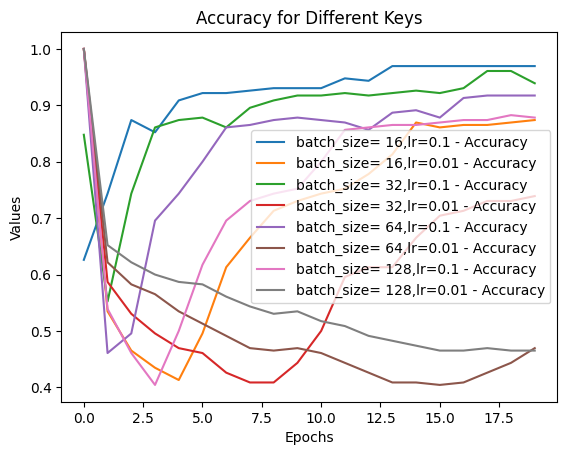

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for key, values in result.items():
    accuracy_values = [i[0] for i in values["metric"]['accuracy_test']][::100]
    plt.plot(range(len(accuracy_values)), accuracy_values, label=f'{key} - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Accuracy for Different Keys')
plt.legend()
plt.show()

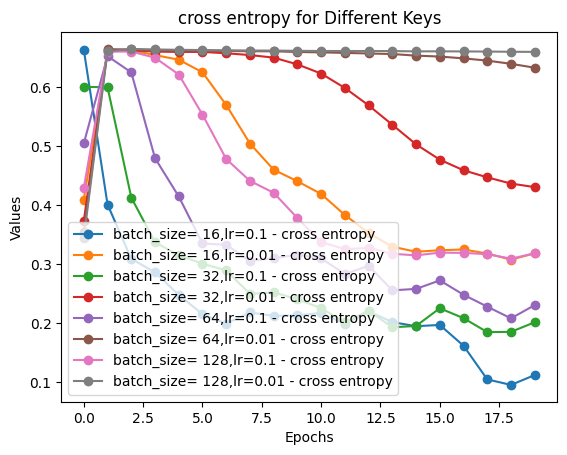

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
for key, values in result.items():
    cross_entropy_values = values["metric"]['cross_entropy_test'][::100]
    plt.plot(range(len(cross_entropy_values)), cross_entropy_values, label=f'{key} - cross entropy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('cross entropy for Different Keys')
plt.legend()
plt.show()

**Without Momentum**

In [ ]:
result={}
k=0
for train_indices,val_indices in custom_kfold_indices(raw_X,raw_y,4,100):
    print("*"*500)
    train_X,train_y = raw_X[train_indices], raw_y[train_indices]
    val_x, val_y = raw_X[val_indices], raw_y[val_indices]
    indices_class_1 = np.where(train_y == 1)[0]
    repeated_indices = np.repeat(indices_class_1, 20)
    train_X_repeated = train_X[repeated_indices]
    train_y_repeated = np.repeat(train_y[indices_class_1], 20)
    train_X_concatenated = np.concatenate((train_X, train_X_repeated), axis=0)
    train_y_concatenated = np.concatenate((train_y, train_y_repeated), axis=0)
    weights,bias,res=MLP(train_X_concatenated,train_y_concatenated,val_x,val_y,[10,2,1],10000,32,0.1,500)
    result[f"k={k}"]={"weights":weights,"bias":bias,"metric":res}
    k+=1

********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 1/10000 [00:00<57:05,  2.92it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5946		0.9648		0.6710		0.5797,			0.0000			0.9973			0.0000			0.9960


  5%|▌         | 502/10000 [00:45<12:24, 12.76it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	1.0000		1.0000		0.8442		0.1818		0.9255		0.8594		0.2263		0.2205,			1.0000			0.8750			1.0000			0.8548


 10%|█         | 1003/10000 [01:26<11:48, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		1.0000		0.9197		0.3200		0.9647		0.9336		0.1184		0.1207,			1.0000			0.9409			1.0000			0.9315


 15%|█▌        | 1502/10000 [02:07<11:14, 12.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1501	1.0000		1.0000		0.9474		0.5714		0.9776		0.9766		0.0835		0.0945,			1.0000			0.9624			1.0000			0.9758


 20%|██        | 2002/10000 [03:11<22:44,  5.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2001	1.0000		1.0000		0.9564		0.5333		0.9816		0.9727		0.0720		0.0887,			1.0000			0.9691			1.0000			0.9718


 25%|██▌       | 2503/10000 [03:53<11:22, 10.98it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2501	1.0000		1.0000		0.9492		0.5714		0.9784		0.9766		0.0560		0.0569,			1.0000			0.9637			1.0000			0.9758


 30%|███       | 3002/10000 [04:34<09:17, 12.56it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3001	1.0000		1.0000		0.9545		0.6154		0.9808		0.9805		0.0432		0.0371,			1.0000			0.9677			1.0000			0.9798


 35%|███▌      | 3502/10000 [05:16<08:37, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3501	1.0000		1.0000		0.9805		0.6667		0.9920		0.9844		0.0324		0.0261,			1.0000			0.9866			1.0000			0.9839


 40%|████      | 4003/10000 [05:58<07:54, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4001	1.0000		1.0000		0.9960		1.0000		0.9984		1.0000		0.0235		0.0169,			1.0000			0.9973			1.0000			1.0000


 45%|████▌     | 4502/10000 [06:39<08:22, 10.93it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0177		0.0108,			1.0000			1.0000			1.0000			1.0000


 50%|█████     | 5002/10000 [07:21<06:28, 12.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5001	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0137		0.0080,			1.0000			1.0000			1.0000			1.0000


 55%|█████▌    | 5502/10000 [08:02<05:53, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0106		0.0069,			1.0000			1.0000			1.0000			1.0000


 60%|██████    | 6002/10000 [08:43<07:37,  8.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6001	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0087		0.0051,			1.0000			1.0000			1.0000			1.0000


 65%|██████▌   | 6502/10000 [09:33<04:30, 12.94it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0072		0.0049,			1.0000			1.0000			1.0000			1.0000


 70%|███████   | 7003/10000 [10:15<03:57, 12.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7001	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0060		0.0038,			1.0000			1.0000			1.0000			1.0000


 75%|███████▌  | 7503/10000 [10:56<03:14, 12.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0052		0.0032,			1.0000			1.0000			1.0000			1.0000


 80%|████████  | 8002/10000 [11:38<02:32, 13.08it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8001	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0046		0.0026,			1.0000			1.0000			1.0000			1.0000


 85%|████████▌ | 8503/10000 [12:19<01:58, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0040		0.0026,			1.0000			1.0000			1.0000			1.0000


 90%|█████████ | 9003/10000 [13:00<01:20, 12.43it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9001	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0036		0.0020,			1.0000			1.0000			1.0000			1.0000


 95%|█████████▌| 9502/10000 [13:41<00:38, 12.77it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0032		0.0020,			1.0000			1.0000			1.0000			1.0000


100%|██████████| 10000/10000 [14:23<00:00, 11.58it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/10000 [00:00<13:16, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5962		0.9688		0.6790		0.4509,			0.0000			1.0000			0.0000			1.0000


  5%|▌         | 502/10000 [00:41<16:46,  9.44it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	0.5000		0.5000		0.8051		0.1250		0.7492		0.8750		0.4063		0.6463,			0.5000			0.9180			0.5000			0.8871


 10%|█         | 1002/10000 [01:29<11:44, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	0.5000		0.5000		0.8456		0.1667		0.7612		0.9062		0.3692		0.6175,			0.5000			0.9382			0.5000			0.9194


 15%|█▌        | 1502/10000 [02:10<11:26, 12.38it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1501	0.5000		0.5000		0.8690		0.2000		0.7676		0.9219		0.3504		0.6209,			0.5000			0.9489			0.5000			0.9355


 20%|██        | 2002/10000 [02:51<10:57, 12.16it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2001	0.5000		0.5000		0.9130		0.2667		0.7788		0.9414		0.3392		0.5904,			0.5000			0.9677			0.5000			0.9556


 25%|██▌       | 2503/10000 [03:33<09:45, 12.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2501	0.5000		0.5000		0.9130		0.2667		0.7788		0.9414		0.3318		0.5930,			0.5000			0.9677			0.5000			0.9556


 30%|███       | 3003/10000 [04:14<09:33, 12.19it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3001	0.5000		0.5000		0.9231		0.3333		0.7812		0.9531		0.3266		0.5833,			0.5000			0.9718			0.5000			0.9677


 35%|███▌      | 3503/10000 [04:55<08:32, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3501	0.5000		0.5000		0.9231		0.3333		0.7812		0.9531		0.3230		0.5597,			0.5000			0.9718			0.5000			0.9677


 40%|████      | 4002/10000 [05:37<07:49, 12.77it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4001	0.5000		0.5000		0.9231		0.3333		0.7812		0.9531		0.3200		0.5723,			0.5000			0.9718			0.5000			0.9677


 45%|████▌     | 4503/10000 [06:18<07:01, 13.04it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4501	0.5000		0.5000		0.9231		0.3333		0.7812		0.9531		0.3179		0.5834,			0.5000			0.9718			0.5000			0.9677


 50%|█████     | 5003/10000 [06:59<06:26, 12.93it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5001	0.5000		0.5000		0.9509		0.4000		0.7877		0.9609		0.3161		0.5689,			0.5000			0.9825			0.5000			0.9758


 55%|█████▌    | 5503/10000 [07:41<05:48, 12.92it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5501	0.5000		0.5000		0.9509		0.4000		0.7877		0.9609		0.3147		0.5745,			0.5000			0.9825			0.5000			0.9758


 60%|██████    | 6002/10000 [08:22<08:26,  7.89it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6001	0.5000		0.5000		0.9509		0.4000		0.7877		0.9609		0.3137		0.5876,			0.5000			0.9825			0.5000			0.9758


 65%|██████▌   | 6502/10000 [09:03<04:32, 12.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6501	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3126		0.5621,			0.5000			0.9852			0.5000			0.9839


 70%|███████   | 7002/10000 [09:44<03:51, 12.93it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7001	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3118		0.5691,			0.5000			0.9852			0.5000			0.9839


 75%|███████▌  | 7503/10000 [10:25<04:41,  8.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7501	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3111		0.5597,			0.5000			0.9852			0.5000			0.9839


 80%|████████  | 8003/10000 [11:07<02:37, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8001	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3104		0.5638,			0.5000			0.9852			0.5000			0.9839


 85%|████████▌ | 8503/10000 [11:48<01:56, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8501	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3099		0.5529,			0.5000			0.9852			0.5000			0.9839


 90%|█████████ | 9002/10000 [12:29<01:22, 12.08it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9001	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3094		0.5537,			0.5000			0.9852			0.5000			0.9839


 95%|█████████▌| 9503/10000 [13:10<00:38, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9501	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3089		0.5623,			0.5000			0.9852			0.5000			0.9839


100%|██████████| 10000/10000 [13:51<00:00, 12.02it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/10000 [00:00<12:35, 13.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.2083		0.2500		0.2958		0.0323		0.4800		0.7422		0.7014		0.5886,			0.2083			0.6640			0.2500			0.7581


  5%|▌         | 503/10000 [00:41<13:10, 12.02it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	1.0000		1.0000		0.9421		0.1311		0.9752		0.7930		0.1208		0.6477,			1.0000			0.9583			1.0000			0.7863


 10%|█         | 1003/10000 [01:22<11:48, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		1.0000		0.9509		0.1667		0.9792		0.8438		0.0745		0.6059,			1.0000			0.9651			1.0000			0.8387


 15%|█▌        | 1503/10000 [02:05<11:08, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1501	1.0000		1.0000		0.9438		0.2000		0.9760		0.8750		0.0452		0.5226,			1.0000			0.9597			1.0000			0.8710


 20%|██        | 2003/10000 [02:46<11:17, 11.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2001	1.0000		1.0000		0.9960		0.2500		0.9984		0.9062		0.0267		0.4500,			1.0000			0.9973			1.0000			0.9032


 25%|██▌       | 2502/10000 [03:27<12:48,  9.76it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2501	1.0000		1.0000		0.9980		0.2581		0.9992		0.9102		0.0165		0.4914,			1.0000			0.9987			1.0000			0.9073


 30%|███       | 3002/10000 [04:08<09:09, 12.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3001	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0108		0.4818,			1.0000			1.0000			1.0000			0.9113


 35%|███▌      | 3502/10000 [04:50<08:33, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3501	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0078		0.4951,			1.0000			1.0000			1.0000			0.9113


 40%|████      | 4003/10000 [05:32<08:35, 11.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4001	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0059		0.5069,			1.0000			1.0000			1.0000			0.9113


 45%|████▌     | 4503/10000 [06:12<07:11, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4501	1.0000		1.0000		1.0000		0.3333		1.0000		0.9375		0.0047		0.5195,			1.0000			1.0000			1.0000			0.9355


 50%|█████     | 5002/10000 [06:54<06:29, 12.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0039		0.5276,			1.0000			1.0000			1.0000			0.9395


 55%|█████▌    | 5503/10000 [07:36<05:58, 12.54it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0033		0.5352,			1.0000			1.0000			1.0000			0.9395


 60%|██████    | 6002/10000 [08:17<05:09, 12.90it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0028		0.5450,			1.0000			1.0000			1.0000			0.9395


 65%|██████▌   | 6503/10000 [08:59<04:29, 12.99it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0025		0.5540,			1.0000			1.0000			1.0000			0.9395


 70%|███████   | 7003/10000 [09:40<03:58, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0022		0.5601,			1.0000			1.0000			1.0000			0.9395


 75%|███████▌  | 7502/10000 [10:21<03:19, 12.54it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0019		0.5695,			1.0000			1.0000			1.0000			0.9395


 80%|████████  | 8003/10000 [11:03<02:36, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0017		0.5755,			1.0000			1.0000			1.0000			0.9395


 85%|████████▌ | 8503/10000 [11:45<02:03, 12.11it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0016		0.5821,			1.0000			1.0000			1.0000			0.9395


 90%|█████████ | 9003/10000 [12:27<01:37, 10.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0015		0.5878,			1.0000			1.0000			1.0000			0.9395


 95%|█████████▌| 9503/10000 [13:08<00:44, 11.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0013		0.5930,			1.0000			1.0000			1.0000			0.9395


100%|██████████| 10000/10000 [13:51<00:00, 12.03it/s]


********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


  0%|          | 2/10000 [00:00<13:49, 12.05it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5962		0.9688		0.6713		0.5548,			0.0000			1.0000			0.0000			1.0000


  5%|▌         | 503/10000 [00:46<12:26, 12.73it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	1.0000		1.0000		0.9421		0.1231		0.9752		0.7773		0.1340		0.6410,			1.0000			0.9583			1.0000			0.7702


 10%|█         | 1003/10000 [01:31<12:02, 12.46it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	1.0000		1.0000		0.9618		0.1481		0.9840		0.8203		0.0807		0.6839,			1.0000			0.9731			1.0000			0.8145


 15%|█▌        | 1502/10000 [02:14<11:31, 12.28it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1501	1.0000		1.0000		0.9730		0.2353		0.9888		0.8984		0.0500		0.5150,			1.0000			0.9812			1.0000			0.8952


 20%|██        | 2002/10000 [02:57<10:29, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2001	1.0000		1.0000		0.9960		0.2500		0.9984		0.9062		0.0297		0.4757,			1.0000			0.9973			1.0000			0.9032


 25%|██▌       | 2503/10000 [03:41<10:01, 12.46it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2501	1.0000		1.0000		0.9980		0.2581		0.9992		0.9102		0.0180		0.4749,			1.0000			0.9987			1.0000			0.9073


 30%|███       | 3002/10000 [04:23<11:31, 10.13it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3001	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0119		0.5094,			1.0000			1.0000			1.0000			0.9113


 35%|███▌      | 3502/10000 [05:06<08:36, 12.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3501	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0084		0.5091,			1.0000			1.0000			1.0000			0.9113


 40%|████      | 4002/10000 [05:50<07:59, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4001	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0063		0.5181,			1.0000			1.0000			1.0000			0.9113


 45%|████▌     | 4503/10000 [06:33<07:09, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4501	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0050		0.5237,			1.0000			1.0000			1.0000			0.9113


 50%|█████     | 5002/10000 [07:17<06:37, 12.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5001	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0041		0.5362,			1.0000			1.0000			1.0000			0.9113


 55%|█████▌    | 5502/10000 [08:00<06:32, 11.46it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5501	1.0000		1.0000		1.0000		0.2667		1.0000		0.9141		0.0034		0.5398,			1.0000			1.0000			1.0000			0.9113


 60%|██████    | 6002/10000 [08:42<05:21, 12.42it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0029		0.5481,			1.0000			1.0000			1.0000			0.9395


 65%|██████▌   | 6502/10000 [09:24<04:34, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0025		0.5541,			1.0000			1.0000			1.0000			0.9395


 70%|███████   | 7003/10000 [10:06<04:02, 12.36it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0022		0.5624,			1.0000			1.0000			1.0000			0.9395


 75%|███████▌  | 7502/10000 [10:47<04:16,  9.73it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0020		0.5690,			1.0000			1.0000			1.0000			0.9395


 80%|████████  | 8003/10000 [11:28<02:36, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0018		0.5753,			1.0000			1.0000			1.0000			0.9395


 85%|████████▌ | 8502/10000 [12:09<01:57, 12.76it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0016		0.5808,			1.0000			1.0000			1.0000			0.9395


 90%|█████████ | 9003/10000 [12:52<01:29, 11.12it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9001	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0015		0.5861,			1.0000			1.0000			1.0000			0.9395


 95%|█████████▌| 9502/10000 [13:33<00:39, 12.47it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9501	1.0000		1.0000		1.0000		0.3478		1.0000		0.9414		0.0014		0.5917,			1.0000			1.0000			1.0000			0.9395


100%|██████████| 10000/10000 [14:14<00:00, 11.71it/s]


**With momentum**

In [ ]:
result={}
k=0
for train_indices,val_indices in custom_kfold_indices(raw_X,raw_y,4,100):
    print("*"*200)
    train_X,train_y = raw_X[train_indices], raw_y[train_indices]
    val_x, val_y = raw_X[val_indices], raw_y[val_indices]
    indices_class_1 = np.where(train_y == 1)[0]
    repeated_indices = np.repeat(indices_class_1, 20)
    train_X_repeated = train_X[repeated_indices]
    train_y_repeated = np.repeat(train_y[indices_class_1],20)
    train_X_concatenated = np.concatenate((train_X, train_X_repeated), axis=0)
    train_y_concatenated = np.concatenate((train_y, train_y_repeated), axis=0)
    weights,bias,res=MLP_momentum(train_X_concatenated,train_y_concatenated,val_x,val_y,[10,2,1],50000,32,0.1,0.9,100)
    result[f"k={k}"]={"weights":weights,"bias":bias,"metric":res}
    k+=1

********************************************************************************************************************************************************************************************************


  0%|          | 2/50000 [00:00<1:11:58, 11.58it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.2083		0.0000		0.4687		0.0000		0.5849		0.7930		0.6719		0.6363,			0.2083			0.8401			0.0000			0.8185


  0%|          | 103/50000 [00:08<1:10:47, 11.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
101	1.0000		1.0000		0.9231		0.3077		0.9663		0.9297		0.1200		0.1386,			1.0000			0.9435			1.0000			0.9274


  0%|          | 203/50000 [00:17<1:08:01, 12.20it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
201	1.0000		1.0000		0.9600		0.6154		0.9832		0.9805		0.0804		0.0715,			1.0000			0.9718			1.0000			0.9798


  1%|          | 303/50000 [00:26<1:14:14, 11.16it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
301	1.0000		1.0000		0.9456		0.5333		0.9768		0.9727		0.0661		0.0868,			1.0000			0.9610			1.0000			0.9718


  1%|          | 403/50000 [00:33<1:05:00, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
401	1.0000		1.0000		0.9527		0.5714		0.9800		0.9766		0.0396		0.0382,			1.0000			0.9664			1.0000			0.9758


  1%|          | 502/50000 [00:42<1:05:07, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	1.0000		1.0000		0.9692		0.8000		0.9872		0.9922		0.0294		0.0205,			1.0000			0.9785			1.0000			0.9919


  1%|          | 603/50000 [00:50<1:05:04, 12.65it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
601	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0115		0.0051,			1.0000			1.0000			1.0000			1.0000


  1%|          | 622/50000 [00:52<1:09:30, 11.84it/s]



 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
623	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0100		0.0060,			1.0000			1.0000			1.0000			1.0000
********************************************************************************************************************************************************************************************************


  0%|          | 2/50000 [00:00<1:04:49, 12.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5962		0.9688		0.6901		0.4214,			0.0000			1.0000			0.0000			1.0000


  0%|          | 102/50000 [00:08<1:04:15, 12.94it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
101	1.0000		1.0000		0.9600		0.4211		0.9832		0.9570		0.1142		0.1327,			1.0000			0.9718			1.0000			0.9556


  0%|          | 202/50000 [00:16<1:04:41, 12.83it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
201	1.0000		1.0000		0.9618		0.6154		0.9840		0.9805		0.0721		0.0962,			1.0000			0.9731			1.0000			0.9798


  1%|          | 302/50000 [00:24<1:05:11, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
301	1.0000		1.0000		0.9902		1.0000		0.9960		1.0000		0.0761		0.0202,			1.0000			0.9933			1.0000			1.0000


  1%|          | 403/50000 [00:33<1:05:33, 12.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
401	1.0000		1.0000		0.9767		0.6154		0.9904		0.9805		0.0298		0.0292,			1.0000			0.9839			1.0000			0.9798


  1%|          | 503/50000 [00:41<1:04:49, 12.73it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0181		0.0067,			1.0000			1.0000			1.0000			1.0000


  1%|          | 568/50000 [00:46<1:08:04, 12.10it/s]



 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
569	1.0000		1.0000		1.0000		1.0000		1.0000		1.0000		0.0100		0.0050,			1.0000			1.0000			1.0000			1.0000
********************************************************************************************************************************************************************************************************


  0%|          | 2/50000 [00:00<1:03:27, 13.13it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1	0.0000		0.0000		0.0000		0.0000		0.5962		0.9688		0.6848		0.6460,			0.0000			1.0000			0.0000			1.0000


  0%|          | 103/50000 [00:08<1:05:21, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
101	0.5000		0.5000		0.8630		0.1667		0.7660		0.9062		0.3736		0.5949,			0.5000			0.9462			0.5000			0.9194


  0%|          | 203/50000 [00:16<1:05:26, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
201	0.5000		0.5000		0.9000		0.2500		0.7756		0.9375		0.3437		0.6051,			0.5000			0.9624			0.5000			0.9516


  1%|          | 303/50000 [00:24<1:05:08, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
301	0.5000		0.5000		0.9130		0.2667		0.7788		0.9414		0.3283		0.6130,			0.5000			0.9677			0.5000			0.9556


  1%|          | 403/50000 [00:33<1:04:15, 12.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
401	0.5000		0.5000		0.9231		0.3333		0.7812		0.9531		0.3207		0.5637,			0.5000			0.9718			0.5000			0.9677


  1%|          | 503/50000 [00:41<1:05:58, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
501	0.5000		0.5000		0.9509		0.4000		0.7877		0.9609		0.3171		0.5386,			0.5000			0.9825			0.5000			0.9758


  1%|          | 602/50000 [00:50<1:10:15, 11.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
601	0.5000		0.5000		0.9509		0.4000		0.7877		0.9609		0.3141		0.5857,			0.5000			0.9825			0.5000			0.9758


  1%|▏         | 702/50000 [00:57<1:04:07, 12.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
701	1.0000		0.5000		0.6545		0.0183		0.7869		0.1445		0.3138		0.6395,			1.0000			0.6425			0.5000			0.1331


  2%|▏         | 802/50000 [01:06<1:05:21, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
801	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3104		0.5723,			0.5000			0.9852			0.5000			0.9839


  2%|▏         | 902/50000 [01:15<1:04:02, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
901	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3090		0.5754,			0.5000			0.9852			0.5000			0.9839


  2%|▏         | 1002/50000 [01:23<1:15:13, 10.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1001	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3081		0.5417,			0.5000			0.9852			0.5000			0.9839


  2%|▏         | 1102/50000 [01:31<1:05:06, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1101	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3073		0.5341,			0.5000			0.9852			0.5000			0.9839


  2%|▏         | 1203/50000 [01:40<1:03:56, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1201	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3061		0.5790,			0.5000			0.9852			0.5000			0.9839


  3%|▎         | 1302/50000 [01:48<1:03:00, 12.88it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1301	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3051		0.5763,			0.5000			0.9852			0.5000			0.9839


  3%|▎         | 1403/50000 [01:56<1:27:07,  9.30it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1401	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3046		0.5481,			0.5000			0.9852			0.5000			0.9839


  3%|▎         | 1503/50000 [02:04<1:04:01, 12.62it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1501	0.5000		0.5000		0.9582		0.5000		0.7893		0.9688		0.3039		0.5774,			0.5000			0.9852			0.5000			0.9839


  3%|▎         | 1602/50000 [02:13<1:03:13, 12.76it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1601	1.0000		1.0000		0.6640		0.0364		0.7957		0.1719		0.3053		0.6367,			1.0000			0.6573			1.0000			0.1452


  3%|▎         | 1702/50000 [02:21<1:04:32, 12.47it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1701	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.3029		0.5485,			0.5000			0.9906			0.5000			0.9879


  4%|▎         | 1802/50000 [02:29<1:25:12,  9.43it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1801	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.3022		0.5765,			0.5000			0.9906			0.5000			0.9879


  4%|▍         | 1903/50000 [02:37<1:05:35, 12.22it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
1901	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.3018		0.5997,			0.5000			0.9906			0.5000			0.9879


  4%|▍         | 2002/50000 [02:46<1:02:28, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2001	1.0000		1.0000		0.6675		0.0365		0.7989		0.1758		0.3031		0.6446,			1.0000			0.6626			1.0000			0.1492


  4%|▍         | 2103/50000 [02:54<1:02:51, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2101	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.3007		0.5391,			0.5000			0.9906			0.5000			0.9879


  4%|▍         | 2203/50000 [03:02<1:03:13, 12.60it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2201	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.3002		0.5945,			0.5000			0.9906			0.5000			0.9879


  5%|▍         | 2302/50000 [03:11<1:03:06, 12.60it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2301	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.2998		0.5444,			0.5000			0.9906			0.5000			0.9879


  5%|▍         | 2402/50000 [03:19<1:03:59, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2401	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.2996		0.5333,			0.5000			0.9906			0.5000			0.9879


  5%|▌         | 2502/50000 [03:28<1:04:17, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2501	0.5000		0.5000		0.9844		0.5714		0.7949		0.9727		0.2992		0.5322,			0.5000			0.9946			0.5000			0.9879


  5%|▌         | 2602/50000 [03:36<1:04:12, 12.30it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2601	0.5000		0.5000		0.9730		0.5714		0.7925		0.9727		0.2985		0.5879,			0.5000			0.9906			0.5000			0.9879


  5%|▌         | 2703/50000 [03:44<1:02:12, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2701	0.5000		0.5000		0.9960		0.8000		0.7973		0.9805		0.2982		0.5830,			0.5000			0.9987			0.5000			0.9960


  6%|▌         | 2803/50000 [03:53<1:02:20, 12.62it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2801	0.5000		0.5000		0.9960		0.8000		0.7973		0.9805		0.2974		0.5849,			0.5000			0.9987			0.5000			0.9960


  6%|▌         | 2903/50000 [04:01<1:01:26, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
2901	0.5000		0.5000		0.9960		0.8000		0.7973		0.9805		0.2945		0.5789,			0.5000			0.9987			0.5000			0.9960


  6%|▌         | 3003/50000 [04:09<1:02:02, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3001	1.0000		1.0000		0.7029		0.0383		0.8293		0.2148		0.2934		0.6241,			1.0000			0.7137			1.0000			0.1895


  6%|▌         | 3102/50000 [04:18<1:00:51, 12.84it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3101	1.0000		1.0000		0.7069		0.0383		0.8325		0.2148		0.2919		0.6406,			1.0000			0.7191			1.0000			0.1895


  6%|▋         | 3203/50000 [04:26<1:03:20, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3201	0.5000		0.5000		0.9960		0.8000		0.7973		0.9805		0.2892		0.5780,			0.5000			0.9987			0.5000			0.9960


  7%|▋         | 3303/50000 [04:35<1:01:18, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3301	0.5000		0.5000		0.5972		0.0202		0.6619		0.2266		0.2884		0.5890,			0.5000			0.7715			0.5000			0.2177


  7%|▋         | 3401/50000 [04:43<1:22:15,  9.44it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3401	0.5000		0.5000		0.5676		0.0198		0.6442		0.2109		0.2881		0.6101,			0.5000			0.7419			0.5000			0.2016


  7%|▋         | 3503/50000 [04:51<59:30, 13.02it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3501	0.5000		0.5000		0.5780		0.0199		0.6506		0.2148		0.2859		0.6023,			0.5000			0.7527			0.5000			0.2056


  7%|▋         | 3602/50000 [05:00<1:01:17, 12.62it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3601	0.5000		0.5000		0.6087		0.0202		0.6683		0.2266		0.2851		0.5869,			0.5000			0.7823			0.5000			0.2177


  7%|▋         | 3703/50000 [05:08<1:02:43, 12.30it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3701	1.0000		1.0000		0.7262		0.0388		0.8478		0.2266		0.2862		0.6360,			1.0000			0.7446			1.0000			0.2016


  8%|▊         | 3803/50000 [05:16<1:01:32, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3801	0.5000		0.5000		0.5753		0.0199		0.6490		0.2148		0.2844		0.6179,			0.5000			0.7500			0.5000			0.2056


  8%|▊         | 3903/50000 [05:25<59:53, 12.83it/s]  


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
3901	1.0000		1.0000		0.7262		0.0388		0.8478		0.2266		0.2860		0.6423,			1.0000			0.7446			1.0000			0.2016


  8%|▊         | 4002/50000 [05:33<58:58, 13.00it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4001	0.5000		0.5000		0.6131		0.0202		0.6707		0.2266		0.2834		0.5837,			0.5000			0.7863			0.5000			0.2177


  8%|▊         | 4102/50000 [05:41<1:01:38, 12.41it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4101	0.5000		0.5000		0.5915		0.0199		0.6587		0.2148		0.2822		0.5977,			0.5000			0.7661			0.5000			0.2056


  8%|▊         | 4202/50000 [05:49<59:18, 12.87it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4201	1.0000		1.0000		0.7326		0.0390		0.8526		0.2305		0.2815		0.6673,			1.0000			0.7527			1.0000			0.2056


  9%|▊         | 4303/50000 [05:58<1:01:44, 12.34it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4301	0.5833		0.5000		0.6203		0.0199		0.6875		0.2148		0.2808		0.6181,			0.5833			0.7581			0.5000			0.2056


  9%|▉         | 4403/50000 [06:06<1:00:51, 12.49it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4401	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2816		0.6492,			1.0000			0.7540			1.0000			0.2056


  9%|▉         | 4503/50000 [06:15<1:05:45, 11.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4501	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2805		0.6335,			1.0000			0.7540			1.0000			0.2056


  9%|▉         | 4603/50000 [06:23<59:39, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4601	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2809		0.5970,			0.5000			0.7648			0.5000			0.2056


  9%|▉         | 4702/50000 [06:31<59:05, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4701	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2799		0.6368,			1.0000			0.7540			1.0000			0.2056


 10%|▉         | 4803/50000 [06:39<57:54, 13.01it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4801	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2793		0.6267,			1.0000			0.7540			1.0000			0.2056


 10%|▉         | 4903/50000 [06:48<1:24:42,  8.87it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
4901	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2802		0.6480,			1.0000			0.7540			1.0000			0.2056


 10%|█         | 5003/50000 [06:56<59:58, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5001	0.7083		1.0000		0.6599		0.0390		0.7348		0.2305		0.2808		0.6236,			0.7083			0.7527			1.0000			0.2056


 10%|█         | 5102/50000 [07:04<58:33, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5101	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2785		0.6422,			1.0000			0.7540			1.0000			0.2056


 10%|█         | 5203/50000 [07:13<59:24, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5201	0.5833		0.5000		0.6269		0.0199		0.6915		0.2148		0.2781		0.6142,			0.5833			0.7648			0.5000			0.2056


 11%|█         | 5302/50000 [07:21<1:25:49,  8.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5301	0.5000		0.5000		0.5957		0.0199		0.6611		0.2148		0.2779		0.6013,			0.5000			0.7702			0.5000			0.2056


 11%|█         | 5403/50000 [07:29<57:50, 12.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5401	0.5000		0.5000		0.5874		0.0199		0.6562		0.2148		0.2792		0.6056,			0.5000			0.7621			0.5000			0.2056


 11%|█         | 5503/50000 [07:38<58:33, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5501	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2791		0.6555,			1.0000			0.7540			1.0000			0.2056


 11%|█         | 5602/50000 [07:46<59:10, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5601	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2790		0.6478,			1.0000			0.7608			1.0000			0.2056


 11%|█▏        | 5702/50000 [07:54<1:13:33, 10.04it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5701	1.0000		1.0000		0.7273		0.0388		0.8486		0.2266		0.2768		0.6801,			1.0000			0.7460			1.0000			0.2016


 12%|█▏        | 5803/50000 [08:02<58:41, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5801	1.0000		1.0000		0.7231		0.0385		0.8454		0.2188		0.2792		0.6807,			1.0000			0.7406			1.0000			0.1935


 12%|█▏        | 5903/50000 [08:11<58:10, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
5901	1.0000		1.0000		0.7294		0.0388		0.8502		0.2266		0.2762		0.6778,			1.0000			0.7487			1.0000			0.2016


 12%|█▏        | 6002/50000 [08:20<57:40, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6001	1.0000		1.0000		0.7368		0.0390		0.8558		0.2305		0.2762		0.6263,			1.0000			0.7581			1.0000			0.2056


 12%|█▏        | 6102/50000 [08:29<1:31:01,  8.04it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6101	1.0000		1.0000		0.7315		0.0390		0.8518		0.2305		0.2783		0.6760,			1.0000			0.7513			1.0000			0.2056


 12%|█▏        | 6203/50000 [08:37<57:22, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6201	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2754		0.6356,			1.0000			0.7648			1.0000			0.2056


 13%|█▎        | 6303/50000 [08:45<57:22, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2748		0.6444,			1.0000			0.7648			1.0000			0.2056


 13%|█▎        | 6403/50000 [08:54<56:27, 12.87it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6401	1.0000		1.0000		0.7210		0.0386		0.8438		0.2227		0.2838		0.6742,			1.0000			0.7379			1.0000			0.1976


 13%|█▎        | 6502/50000 [09:02<1:21:25,  8.90it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2775		0.6509,			1.0000			0.7648			1.0000			0.2056


 13%|█▎        | 6603/50000 [09:10<59:59, 12.06it/s]  


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6601	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2815		0.6071,			0.5000			0.7648			0.5000			0.2056


 13%|█▎        | 6702/50000 [09:19<56:28, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6701	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2774		0.6723,			1.0000			0.7540			1.0000			0.2056


 14%|█▎        | 6803/50000 [09:27<56:30, 12.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6801	0.5000		0.5000		0.6072		0.0202		0.6675		0.2266		0.2756		0.5885,			0.5000			0.7809			0.5000			0.2177


 14%|█▍        | 6901/50000 [09:35<57:18, 12.54it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
6901	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2742		0.6519,			1.0000			0.7621			1.0000			0.2056


 14%|█▍        | 7002/50000 [09:43<55:44, 12.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7001	1.0000		1.0000		0.7304		0.0390		0.8510		0.2305		0.2748		0.6627,			1.0000			0.7500			1.0000			0.2056


 14%|█▍        | 7102/50000 [09:52<55:01, 12.99it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7101	0.5000		0.5000		0.6161		0.0202		0.6723		0.2266		0.2755		0.5818,			0.5000			0.7890			0.5000			0.2177


 14%|█▍        | 7202/50000 [10:00<59:02, 12.08it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7201	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2738		0.6586,			1.0000			0.7540			1.0000			0.2056


 15%|█▍        | 7302/50000 [10:08<58:28, 12.17it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7301	0.5000		0.5000		0.5986		0.0199		0.6627		0.2148		0.2742		0.6008,			0.5000			0.7728			0.5000			0.2056


 15%|█▍        | 7402/50000 [10:17<56:48, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7401	0.5000		0.5000		0.6176		0.0202		0.6731		0.2266		0.2745		0.5869,			0.5000			0.7903			0.5000			0.2177


 15%|█▌        | 7503/50000 [10:25<55:19, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7501	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2737		0.6543,			1.0000			0.7540			1.0000			0.2056


 15%|█▌        | 7603/50000 [10:34<56:13, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2734		0.6257,			1.0000			0.7648			1.0000			0.2056


 15%|█▌        | 7703/50000 [10:42<55:36, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7701	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2731		0.6525,			1.0000			0.7648			1.0000			0.2056


 16%|█▌        | 7802/50000 [10:50<55:11, 12.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7801	1.0000		1.0000		0.7412		0.0390		0.8590		0.2305		0.2746		0.6452,			1.0000			0.7634			1.0000			0.2056


 16%|█▌        | 7902/50000 [10:59<55:11, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
7901	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2738		0.6488,			1.0000			0.7648			1.0000			0.2056


 16%|█▌        | 8003/50000 [11:07<57:55, 12.09it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2727		0.6502,			1.0000			0.7648			1.0000			0.2056


 16%|█▌        | 8103/50000 [11:15<55:01, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8101	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2744		0.6018,			0.5000			0.7648			0.5000			0.2056


 16%|█▋        | 8203/50000 [11:23<54:57, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8201	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2725		0.6319,			1.0000			0.7648			1.0000			0.2056


 17%|█▋        | 8302/50000 [11:32<54:43, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2724		0.6484,			1.0000			0.7648			1.0000			0.2056


 17%|█▋        | 8403/50000 [11:40<58:08, 11.92it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8401	1.0000		1.0000		0.7273		0.0386		0.8486		0.2227		0.2780		0.7034,			1.0000			0.7460			1.0000			0.1976


 17%|█▋        | 8503/50000 [11:48<54:39, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8501	0.5000		0.5000		0.5847		0.0199		0.6546		0.2148		0.2756		0.5986,			0.5000			0.7594			0.5000			0.2056


 17%|█▋        | 8603/50000 [11:57<54:08, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8601	1.0000		1.0000		0.7412		0.0390		0.8590		0.2305		0.2732		0.6718,			1.0000			0.7634			1.0000			0.2056


 17%|█▋        | 8703/50000 [12:06<54:28, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8701	0.5000		0.5000		0.6161		0.0203		0.6723		0.2305		0.2759		0.5751,			0.5000			0.7890			0.5000			0.2218


 18%|█▊        | 8802/50000 [12:14<55:47, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8801	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2721		0.6191,			1.0000			0.7648			1.0000			0.2056


 18%|█▊        | 8902/50000 [12:22<53:33, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
8901	1.0000		0.6250		0.7231		0.0248		0.8454		0.2188		0.2819		0.6301,			1.0000			0.7406			0.6250			0.2056


 18%|█▊        | 9003/50000 [12:31<54:04, 12.64it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2730		0.6428,			1.0000			0.7648			1.0000			0.2056


 18%|█▊        | 9102/50000 [12:39<52:42, 12.93it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9101	1.0000		1.0000		0.7347		0.0390		0.8542		0.2305		0.2767		0.6338,			1.0000			0.7554			1.0000			0.2056


 18%|█▊        | 9203/50000 [12:48<55:29, 12.25it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9201	1.0000		1.0000		0.7315		0.0390		0.8518		0.2305		0.2721		0.6694,			1.0000			0.7513			1.0000			0.2056


 19%|█▊        | 9303/50000 [12:56<53:58, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9301	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2726		0.6570,			1.0000			0.7540			1.0000			0.2056


 19%|█▉        | 9403/50000 [13:05<54:03, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9401	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2713		0.6513,			1.0000			0.7648			1.0000			0.2056


 19%|█▉        | 9503/50000 [13:13<53:53, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9501	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2736		0.6412,			1.0000			0.7540			1.0000			0.2056


 19%|█▉        | 9603/50000 [13:22<53:23, 12.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2719		0.6312,			1.0000			0.7648			1.0000			0.2056


 19%|█▉        | 9703/50000 [13:30<54:24, 12.34it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9701	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2710		0.6588,			1.0000			0.7648			1.0000			0.2056


 20%|█▉        | 9802/50000 [13:38<53:02, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9801	0.9583		0.7500		0.7385		0.0296		0.8462		0.2227		0.2729		0.6140,			0.9583			0.7702			0.7500			0.2056


 20%|█▉        | 9903/50000 [13:47<52:45, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
9901	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2735		0.6407,			1.0000			0.7540			1.0000			0.2056


 20%|██        | 10003/50000 [13:55<54:31, 12.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10001	1.0000		0.7500		0.7467		0.0296		0.8630		0.2227		0.2710		0.6150,			1.0000			0.7702			0.7500			0.2056


 20%|██        | 10103/50000 [14:03<53:11, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10101	1.0000		1.0000		0.7273		0.0386		0.8486		0.2227		0.2715		0.6823,			1.0000			0.7460			1.0000			0.1976


 20%|██        | 10203/50000 [14:12<51:53, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10201	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2720		0.6241,			1.0000			0.7648			1.0000			0.2056


 21%|██        | 10302/50000 [14:20<52:09, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2703		0.6486,			1.0000			0.7648			1.0000			0.2056


 21%|██        | 10403/50000 [14:29<53:50, 12.26it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10401	1.0000		1.0000		0.7252		0.0385		0.8470		0.2188		0.2979		0.6739,			1.0000			0.7433			1.0000			0.1935


 21%|██        | 10503/50000 [14:36<52:19, 12.58it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2707		0.6585,			1.0000			0.7648			1.0000			0.2056


 21%|██        | 10603/50000 [14:45<51:09, 12.83it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2725		0.6384,			1.0000			0.7648			1.0000			0.2056


 21%|██▏       | 10703/50000 [14:53<51:26, 12.73it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10701	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2705		0.6516,			1.0000			0.7648			1.0000			0.2056


 22%|██▏       | 10803/50000 [15:02<58:05, 11.25it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10801	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2713		0.6674,			1.0000			0.7540			1.0000			0.2056


 22%|██▏       | 10903/50000 [15:10<51:07, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
10901	1.0000		1.0000		0.7336		0.0385		0.8534		0.2188		0.2852		0.6906,			1.0000			0.7540			1.0000			0.1935


 22%|██▏       | 11003/50000 [15:18<51:54, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2699		0.6486,			1.0000			0.7648			1.0000			0.2056


 22%|██▏       | 11103/50000 [15:27<51:37, 12.56it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11101	1.0000		0.7500		0.7489		0.0296		0.8646		0.2227		0.2707		0.6164,			1.0000			0.7728			0.7500			0.2056


 22%|██▏       | 11202/50000 [15:36<1:08:03,  9.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11201	1.0000		1.0000		0.7179		0.0386		0.8413		0.2227		0.2777		0.6386,			1.0000			0.7339			1.0000			0.1976


 23%|██▎       | 11302/50000 [15:44<52:42, 12.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2712		0.6423,			1.0000			0.7648			1.0000			0.2056


 23%|██▎       | 11403/50000 [15:52<52:20, 12.29it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11401	0.9583		0.8750		0.7408		0.0343		0.8478		0.2266		0.2800		0.6265,			0.9583			0.7728			0.8750			0.2056


 23%|██▎       | 11502/50000 [16:01<52:52, 12.13it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2743		0.7075,			1.0000			0.7513			1.0000			0.1935


 23%|██▎       | 11602/50000 [16:09<1:11:26,  8.96it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2711		0.6448,			1.0000			0.7648			1.0000			0.2056


 23%|██▎       | 11702/50000 [16:17<51:50, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11701	0.8750		0.8750		0.7230		0.0343		0.8141		0.2266		0.2718		0.6172,			0.8750			0.7728			0.8750			0.2056


 24%|██▎       | 11802/50000 [16:26<51:12, 12.43it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11801	1.0000		1.0000		0.7210		0.0386		0.8438		0.2227		0.2791		0.6656,			1.0000			0.7379			1.0000			0.1976


 24%|██▍       | 11903/50000 [16:34<51:41, 12.28it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
11901	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2701		0.6252,			1.0000			0.7648			1.0000			0.2056


 24%|██▍       | 12002/50000 [16:42<1:16:03,  8.33it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12001	1.0000		1.0000		0.7326		0.0386		0.8526		0.2227		0.2714		0.6786,			1.0000			0.7527			1.0000			0.1976


 24%|██▍       | 12102/50000 [16:50<49:25, 12.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12101	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2701		0.6473,			1.0000			0.7648			1.0000			0.2056


 24%|██▍       | 12203/50000 [16:59<50:08, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12201	1.0000		1.0000		0.7390		0.0385		0.8574		0.2188		0.2892		0.6904,			1.0000			0.7608			1.0000			0.1935


 25%|██▍       | 12303/50000 [17:08<49:20, 12.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12301	1.0000		1.0000		0.7368		0.0390		0.8558		0.2305		0.2726		0.6550,			1.0000			0.7581			1.0000			0.2056


 25%|██▍       | 12401/50000 [17:15<1:04:50,  9.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12401	1.0000		1.0000		0.7231		0.0385		0.8454		0.2188		0.2740		0.6842,			1.0000			0.7406			1.0000			0.1935


 25%|██▌       | 12502/50000 [17:24<51:13, 12.20it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2790		0.6967,			1.0000			0.7513			1.0000			0.1935


 25%|██▌       | 12603/50000 [17:33<57:36, 10.82it/s]  


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2694		0.6442,			1.0000			0.7648			1.0000			0.2056


 25%|██▌       | 12702/50000 [17:41<50:10, 12.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12701	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2699		0.6286,			1.0000			0.7728			1.0000			0.2056


 26%|██▌       | 12802/50000 [17:50<1:19:25,  7.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12801	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2706		0.6247,			1.0000			0.7648			1.0000			0.2056


 26%|██▌       | 12903/50000 [17:58<49:24, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
12901	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2692		0.6909,			1.0000			0.7513			1.0000			0.1935


 26%|██▌       | 13002/50000 [18:06<49:44, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2691		0.6476,			1.0000			0.7648			1.0000			0.2056


 26%|██▌       | 13102/50000 [18:15<48:14, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13101	1.0000		1.0000		0.7326		0.0386		0.8526		0.2227		0.2700		0.6641,			1.0000			0.7527			1.0000			0.1976


 26%|██▋       | 13202/50000 [18:23<1:08:29,  8.95it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13201	0.5000		0.5000		0.6222		0.0202		0.6755		0.2266		0.2709		0.5802,			0.5000			0.7944			0.5000			0.2177


 27%|██▋       | 13302/50000 [18:31<50:37, 12.08it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13301	0.7917		0.7500		0.7025		0.0296		0.7804		0.2227		0.2709		0.6168,			0.7917			0.7728			0.7500			0.2056


 27%|██▋       | 13403/50000 [18:40<48:20, 12.62it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13401	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2700		0.6552,			1.0000			0.7648			1.0000			0.2056


 27%|██▋       | 13502/50000 [18:48<48:40, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13501	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2708		0.6055,			0.5000			0.7648			0.5000			0.2056


 27%|██▋       | 13602/50000 [18:57<1:30:25,  6.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13601	1.0000		1.0000		0.7467		0.0390		0.8630		0.2305		0.2720		0.6293,			1.0000			0.7702			1.0000			0.2056


 27%|██▋       | 13703/50000 [19:05<48:22, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13701	1.0000		1.0000		0.7456		0.0390		0.8622		0.2305		0.2685		0.6312,			1.0000			0.7688			1.0000			0.2056


 28%|██▊       | 13802/50000 [19:14<48:11, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13801	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2696		0.6237,			1.0000			0.7728			1.0000			0.2056


 28%|██▊       | 13902/50000 [19:22<47:23, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
13901	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2719		0.6222,			1.0000			0.7540			1.0000			0.2056


 28%|██▊       | 14002/50000 [19:30<59:08, 10.14it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2686		0.6459,			1.0000			0.7648			1.0000			0.2056


 28%|██▊       | 14102/50000 [19:38<47:03, 12.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14101	1.0000		1.0000		0.7347		0.0390		0.8542		0.2305		0.2687		0.6593,			1.0000			0.7554			1.0000			0.2056


 28%|██▊       | 14203/50000 [19:47<48:46, 12.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14201	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2697		0.6418,			1.0000			0.7661			1.0000			0.2056


 29%|██▊       | 14302/50000 [19:56<48:07, 12.36it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14301	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2683		0.6636,			1.0000			0.7621			1.0000			0.2056


 29%|██▉       | 14402/50000 [20:04<51:27, 11.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14401	1.0000		1.0000		0.7283		0.0385		0.8494		0.2188		0.2718		0.6711,			1.0000			0.7473			1.0000			0.1935


 29%|██▉       | 14503/50000 [20:12<46:09, 12.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14501	1.0000		1.0000		0.7347		0.0390		0.8542		0.2305		0.2696		0.6481,			1.0000			0.7554			1.0000			0.2056


 29%|██▉       | 14602/50000 [20:20<46:00, 12.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14601	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2691		0.7225,			1.0000			0.7513			1.0000			0.1935


 29%|██▉       | 14703/50000 [20:29<46:34, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14701	1.0000		1.0000		0.7445		0.0390		0.8614		0.2305		0.2678		0.6399,			1.0000			0.7675			1.0000			0.2056


 30%|██▉       | 14803/50000 [20:37<45:46, 12.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14801	1.0000		1.0000		0.7283		0.0385		0.8494		0.2188		0.2720		0.6782,			1.0000			0.7473			1.0000			0.1935


 30%|██▉       | 14902/50000 [20:45<46:08, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
14901	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2687		0.6823,			1.0000			0.7513			1.0000			0.1935


 30%|███       | 15002/50000 [20:54<49:48, 11.71it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15001	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2682		0.6573,			1.0000			0.7661			1.0000			0.2056


 30%|███       | 15102/50000 [21:02<46:33, 12.49it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15101	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2677		0.6577,			1.0000			0.7608			1.0000			0.2056


 30%|███       | 15202/50000 [21:10<45:50, 12.65it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15201	1.0000		1.0000		0.7294		0.0385		0.8502		0.2188		0.2700		0.6720,			1.0000			0.7487			1.0000			0.1935


 31%|███       | 15303/50000 [21:19<46:11, 12.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2682		0.6551,			1.0000			0.7648			1.0000			0.2056


 31%|███       | 15402/50000 [21:27<45:20, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15401	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2708		0.6504,			1.0000			0.7648			1.0000			0.2056


 31%|███       | 15502/50000 [21:36<48:53, 11.76it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2690		0.6360,			1.0000			0.7648			1.0000			0.2056


 31%|███       | 15602/50000 [21:44<44:29, 12.89it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15601	1.0000		1.0000		0.7412		0.0390		0.8590		0.2305		0.2682		0.6555,			1.0000			0.7634			1.0000			0.2056


 31%|███▏      | 15702/50000 [21:52<43:51, 13.03it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15701	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2678		0.6340,			1.0000			0.7728			1.0000			0.2056


 32%|███▏      | 15803/50000 [22:01<45:57, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15801	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2716		0.5970,			0.5000			0.7648			0.5000			0.2056


 32%|███▏      | 15902/50000 [22:09<46:43, 12.16it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
15901	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2677		0.6347,			1.0000			0.7661			1.0000			0.2056


 32%|███▏      | 16002/50000 [22:18<44:13, 12.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16001	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2670		0.6535,			1.0000			0.7648			1.0000			0.2056


 32%|███▏      | 16103/50000 [22:26<43:30, 12.98it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16101	0.5000		0.5000		0.5915		0.0201		0.6587		0.2227		0.2739		0.5795,			0.5000			0.7661			0.5000			0.2137


 32%|███▏      | 16203/50000 [22:35<44:30, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16201	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2684		0.6865,			1.0000			0.7513			1.0000			0.1935


 33%|███▎      | 16302/50000 [22:44<43:35, 12.89it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16301	1.0000		0.7500		0.7347		0.0296		0.8542		0.2227		0.2896		0.6764,			1.0000			0.7554			0.7500			0.2056


 33%|███▎      | 16402/50000 [22:51<43:43, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16401	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2704		0.6477,			1.0000			0.7540			1.0000			0.2056


 33%|███▎      | 16503/50000 [23:00<44:21, 12.58it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16501	0.5000		0.5000		0.5986		0.0199		0.6627		0.2148		0.2696		0.6063,			0.5000			0.7728			0.5000			0.2056


 33%|███▎      | 16602/50000 [23:08<44:07, 12.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16601	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2698		0.6995,			1.0000			0.7513			1.0000			0.1935


 33%|███▎      | 16703/50000 [23:17<45:13, 12.27it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16701	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2690		0.6302,			1.0000			0.7648			1.0000			0.2056


 34%|███▎      | 16801/50000 [23:25<52:02, 10.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16801	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2681		0.6783,			1.0000			0.7513			1.0000			0.1935


 34%|███▍      | 16902/50000 [23:34<44:15, 12.47it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
16901	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2674		0.6476,			1.0000			0.7648			1.0000			0.2056


 34%|███▍      | 17002/50000 [23:43<45:48, 12.00it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17001	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2673		0.6458,			1.0000			0.7661			1.0000			0.2056


 34%|███▍      | 17103/50000 [23:52<45:09, 12.14it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17101	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2676		0.6287,			1.0000			0.7728			1.0000			0.2056


 34%|███▍      | 17203/50000 [24:02<55:15,  9.89it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17201	1.0000		1.0000		0.7326		0.0385		0.8526		0.2188		0.2679		0.6648,			1.0000			0.7527			1.0000			0.1935


 35%|███▍      | 17303/50000 [24:10<49:02, 11.11it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17301	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2669		0.6763,			1.0000			0.7513			1.0000			0.1935


 35%|███▍      | 17402/50000 [24:19<44:38, 12.17it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17401	1.0000		1.0000		0.7336		0.0388		0.8534		0.2266		0.2723		0.6253,			1.0000			0.7540			1.0000			0.2016


 35%|███▌      | 17502/50000 [24:28<43:13, 12.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2692		0.6941,			1.0000			0.7513			1.0000			0.1935


 35%|███▌      | 17603/50000 [24:37<45:37, 11.83it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17601	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2685		0.6504,			1.0000			0.7608			1.0000			0.2056


 35%|███▌      | 17701/50000 [24:45<52:28, 10.26it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17701	1.0000		1.0000		0.7467		0.0390		0.8630		0.2305		0.2679		0.6530,			1.0000			0.7702			1.0000			0.2056


 36%|███▌      | 17802/50000 [24:54<46:19, 11.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17801	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2669		0.6841,			1.0000			0.7513			1.0000			0.1935


 36%|███▌      | 17901/50000 [25:02<41:59, 12.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
17901	1.0000		1.0000		0.7445		0.0390		0.8614		0.2305		0.2669		0.6422,			1.0000			0.7675			1.0000			0.2056


 36%|███▌      | 18003/50000 [25:12<44:40, 11.94it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18001	1.0000		1.0000		0.7326		0.0390		0.8526		0.2305		0.2699		0.6636,			1.0000			0.7527			1.0000			0.2056


 36%|███▌      | 18103/50000 [25:20<1:01:37,  8.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18101	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2678		0.6529,			1.0000			0.7648			1.0000			0.2056


 36%|███▋      | 18203/50000 [25:28<46:53, 11.30it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18201	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2664		0.6533,			1.0000			0.7608			1.0000			0.2056


 37%|███▋      | 18302/50000 [25:37<41:50, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18301	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2672		0.6366,			1.0000			0.7661			1.0000			0.2056


 37%|███▋      | 18403/50000 [25:46<44:02, 11.96it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18401	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2732		0.6395,			1.0000			0.7621			1.0000			0.2056


 37%|███▋      | 18503/50000 [25:55<47:49, 10.98it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2668		0.6530,			1.0000			0.7648			1.0000			0.2056


 37%|███▋      | 18601/50000 [26:04<46:59, 11.14it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18601	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2705		0.6524,			1.0000			0.7728			1.0000			0.2056


 37%|███▋      | 18702/50000 [26:13<41:21, 12.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18701	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2678		0.6936,			1.0000			0.7513			1.0000			0.1935


 38%|███▊      | 18802/50000 [26:22<48:23, 10.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18801	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2679		0.6464,			1.0000			0.7648			1.0000			0.2056


 38%|███▊      | 18902/50000 [26:31<41:18, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
18901	1.0000		1.0000		0.7283		0.0390		0.8494		0.2305		0.2682		0.6710,			1.0000			0.7473			1.0000			0.2056


 38%|███▊      | 19002/50000 [26:40<56:22,  9.16it/s]  


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19001	1.0000		1.0000		0.7294		0.0388		0.8502		0.2266		0.2688		0.6752,			1.0000			0.7487			1.0000			0.2016


 38%|███▊      | 19102/50000 [26:49<40:09, 12.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19101	0.5000		0.5000		0.5847		0.0199		0.6546		0.2148		0.2718		0.5974,			0.5000			0.7594			0.5000			0.2056


 38%|███▊      | 19203/50000 [26:58<41:46, 12.29it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19201	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2673		0.6776,			1.0000			0.7513			1.0000			0.1935


 39%|███▊      | 19303/50000 [27:07<46:01, 11.12it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2688		0.6394,			1.0000			0.7648			1.0000			0.2056


 39%|███▉      | 19402/50000 [27:16<43:16, 11.78it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19401	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2661		0.6565,			1.0000			0.7648			1.0000			0.2056


 39%|███▉      | 19502/50000 [27:25<50:53,  9.99it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2668		0.6334,			1.0000			0.7648			1.0000			0.2056


 39%|███▉      | 19602/50000 [27:33<39:19, 12.89it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2663		0.6499,			1.0000			0.7648			1.0000			0.2056


 39%|███▉      | 19702/50000 [27:43<44:20, 11.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19701	1.0000		1.0000		0.7221		0.0385		0.8446		0.2188		0.2708		0.6981,			1.0000			0.7392			1.0000			0.1935


 40%|███▉      | 19802/50000 [27:51<40:33, 12.41it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19801	0.5000		0.5000		0.5986		0.0199		0.6627		0.2148		0.2681		0.6030,			0.5000			0.7728			0.5000			0.2056


 40%|███▉      | 19903/50000 [28:00<43:40, 11.48it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
19901	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2663		0.6495,			1.0000			0.7648			1.0000			0.2056


 40%|████      | 20003/50000 [28:09<40:12, 12.44it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20001	1.0000		1.0000		0.7315		0.0390		0.8518		0.2305		0.2715		0.6294,			1.0000			0.7513			1.0000			0.2056


 40%|████      | 20102/50000 [28:17<40:23, 12.34it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20101	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2670		0.6553,			1.0000			0.7661			1.0000			0.2056


 40%|████      | 20202/50000 [28:26<41:47, 11.88it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20201	1.0000		1.0000		0.7149		0.0385		0.8389		0.2188		0.2859		0.6512,			1.0000			0.7298			1.0000			0.1935


 41%|████      | 20303/50000 [28:35<40:23, 12.25it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20301	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2676		0.6238,			1.0000			0.7728			1.0000			0.2056


 41%|████      | 20402/50000 [28:44<1:15:00,  6.58it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20401	1.0000		1.0000		0.7368		0.0390		0.8558		0.2305		0.2662		0.6634,			1.0000			0.7581			1.0000			0.2056


 41%|████      | 20503/50000 [28:53<38:37, 12.73it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20501	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2682		0.6552,			1.0000			0.7648			1.0000			0.2056


 41%|████      | 20602/50000 [29:02<45:20, 10.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20601	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2667		0.6979,			1.0000			0.7513			1.0000			0.1935


 41%|████▏     | 20702/50000 [29:11<39:30, 12.36it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20701	1.0000		1.0000		0.7379		0.0388		0.8566		0.2266		0.2662		0.6659,			1.0000			0.7594			1.0000			0.2016


 42%|████▏     | 20802/50000 [29:19<41:27, 11.74it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20801	1.0000		1.0000		0.7294		0.0390		0.8502		0.2305		0.2735		0.6700,			1.0000			0.7487			1.0000			0.2056


 42%|████▏     | 20902/50000 [29:28<40:04, 12.10it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
20901	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2660		0.6353,			1.0000			0.7728			1.0000			0.2056


 42%|████▏     | 21003/50000 [29:38<42:28, 11.38it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21001	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2666		0.7094,			1.0000			0.7513			1.0000			0.1935


 42%|████▏     | 21103/50000 [29:47<39:14, 12.27it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21101	1.0000		1.0000		0.7456		0.0390		0.8622		0.2305		0.2653		0.6576,			1.0000			0.7688			1.0000			0.2056


 42%|████▏     | 21203/50000 [29:56<41:49, 11.48it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21201	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2690		0.6569,			1.0000			0.7540			1.0000			0.2056


 43%|████▎     | 21302/50000 [30:05<37:39, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21301	1.0000		1.0000		0.7467		0.0390		0.8630		0.2305		0.2664		0.6431,			1.0000			0.7702			1.0000			0.2056


 43%|████▎     | 21402/50000 [30:13<39:36, 12.04it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21401	1.0000		1.0000		0.7412		0.0388		0.8590		0.2266		0.2663		0.6539,			1.0000			0.7634			1.0000			0.2016


 43%|████▎     | 21503/50000 [30:22<45:08, 10.52it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21501	0.5000		0.5000		0.5986		0.0199		0.6627		0.2148		0.2725		0.6149,			0.5000			0.7728			0.5000			0.2056


 43%|████▎     | 21602/50000 [30:30<39:37, 11.95it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21601	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2663		0.6264,			1.0000			0.7728			1.0000			0.2056


 43%|████▎     | 21703/50000 [30:39<37:47, 12.48it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21701	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2665		0.6794,			1.0000			0.7513			1.0000			0.1935


 44%|████▎     | 21801/50000 [30:47<37:42, 12.46it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21801	0.5000		0.5000		0.5902		0.0199		0.6579		0.2148		0.2692		0.5967,			0.5000			0.7648			0.5000			0.2056


 44%|████▍     | 21902/50000 [30:56<37:15, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
21901	1.0000		1.0000		0.7358		0.0386		0.8550		0.2227		0.2661		0.6656,			1.0000			0.7567			1.0000			0.1976


 44%|████▍     | 22002/50000 [31:04<36:47, 12.68it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22001	1.0000		0.5000		0.7336		0.0199		0.8534		0.2148		0.2713		0.6072,			1.0000			0.7540			0.5000			0.2056


 44%|████▍     | 22102/50000 [31:13<37:11, 12.50it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22101	1.0000		0.7500		0.7412		0.0296		0.8590		0.2227		0.2704		0.6199,			1.0000			0.7634			0.7500			0.2056


 44%|████▍     | 22202/50000 [31:21<45:02, 10.29it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22201	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2658		0.6671,			1.0000			0.7513			1.0000			0.1935


 45%|████▍     | 22303/50000 [31:29<36:43, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22301	1.0000		0.6250		0.7489		0.0248		0.8646		0.2188		0.2659		0.6158,			1.0000			0.7728			0.6250			0.2056


 45%|████▍     | 22402/50000 [31:38<37:15, 12.35it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22401	1.0000		1.0000		0.7368		0.0390		0.8558		0.2305		0.2659		0.6609,			1.0000			0.7581			1.0000			0.2056


 45%|████▌     | 22503/50000 [31:47<37:10, 12.33it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2666		0.7044,			1.0000			0.7513			1.0000			0.1935


 45%|████▌     | 22602/50000 [31:55<54:34,  8.37it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22601	1.0000		1.0000		0.7379		0.0388		0.8566		0.2266		0.2666		0.6555,			1.0000			0.7594			1.0000			0.2016


 45%|████▌     | 22702/50000 [32:03<36:29, 12.47it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22701	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2668		0.6869,			1.0000			0.7513			1.0000			0.1935


 46%|████▌     | 22802/50000 [32:12<34:58, 12.96it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22801	1.0000		1.0000		0.7445		0.0390		0.8614		0.2305		0.2656		0.6472,			1.0000			0.7675			1.0000			0.2056


 46%|████▌     | 22903/50000 [32:20<35:38, 12.67it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
22901	1.0000		1.0000		0.7478		0.0390		0.8638		0.2305		0.2658		0.6504,			1.0000			0.7715			1.0000			0.2056


 46%|████▌     | 23002/50000 [32:29<50:51,  8.85it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23001	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2657		0.6937,			1.0000			0.7513			1.0000			0.1935


 46%|████▌     | 23102/50000 [32:37<37:16, 12.03it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23101	0.5000		0.5000		0.6000		0.0199		0.6635		0.2148		0.2669		0.6013,			0.5000			0.7742			0.5000			0.2056


 46%|████▋     | 23202/50000 [32:45<35:42, 12.51it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23201	1.0000		1.0000		0.7262		0.0379		0.8478		0.2070		0.2728		0.7296,			1.0000			0.7446			1.0000			0.1815


 47%|████▋     | 23302/50000 [32:54<36:21, 12.24it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23301	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2662		0.7106,			1.0000			0.7513			1.0000			0.1935


 47%|████▋     | 23403/50000 [33:03<41:55, 10.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23401	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2664		0.6647,			1.0000			0.7608			1.0000			0.2056


 47%|████▋     | 23503/50000 [33:11<35:40, 12.38it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23501	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2696		0.6329,			1.0000			0.7661			1.0000			0.2056


 47%|████▋     | 23602/50000 [33:20<34:30, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23601	1.0000		1.0000		0.7390		0.0390		0.8574		0.2305		0.2656		0.6644,			1.0000			0.7608			1.0000			0.2056


 47%|████▋     | 23702/50000 [33:28<34:32, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23701	0.7083		0.5000		0.6787		0.0199		0.7468		0.2148		0.2664		0.6084,			0.7083			0.7728			0.5000			0.2056


 48%|████▊     | 23802/50000 [33:37<43:32, 10.03it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23801	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2670		0.6335,			1.0000			0.7728			1.0000			0.2056


 48%|████▊     | 23902/50000 [33:45<35:14, 12.34it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
23901	0.5000		0.6250		0.5986		0.0248		0.6627		0.2188		0.2950		0.6096,			0.5000			0.7728			0.6250			0.2056


 48%|████▊     | 24002/50000 [33:53<35:11, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24001	1.0000		1.0000		0.7358		0.0390		0.8550		0.2305		0.2653		0.6637,			1.0000			0.7567			1.0000			0.2056


 48%|████▊     | 24102/50000 [34:02<34:16, 12.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24101	1.0000		1.0000		0.7467		0.0390		0.8630		0.2305		0.2649		0.6553,			1.0000			0.7702			1.0000			0.2056


 48%|████▊     | 24203/50000 [34:10<42:32, 10.11it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24201	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2662		0.6265,			1.0000			0.7728			1.0000			0.2056


 49%|████▊     | 24303/50000 [34:18<33:31, 12.77it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24301	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2672		0.6645,			1.0000			0.7661			1.0000			0.2056


 49%|████▉     | 24403/50000 [34:27<33:55, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24401	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2655		0.6470,			1.0000			0.7728			1.0000			0.2056


 49%|████▉     | 24502/50000 [34:35<34:18, 12.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24501	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2653		0.6263,			1.0000			0.7728			1.0000			0.2056


 49%|████▉     | 24603/50000 [34:44<41:05, 10.30it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24601	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2664		0.6414,			1.0000			0.7728			1.0000			0.2056


 49%|████▉     | 24703/50000 [34:52<34:00, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24701	1.0000		1.0000		0.7379		0.0386		0.8566		0.2227		0.2669		0.6734,			1.0000			0.7594			1.0000			0.1976


 50%|████▉     | 24802/50000 [35:00<33:51, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24801	1.0000		1.0000		0.7347		0.0388		0.8542		0.2266		0.2650		0.6622,			1.0000			0.7554			1.0000			0.2016


 50%|████▉     | 24903/50000 [35:09<34:23, 12.16it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
24901	1.0000		1.0000		0.7379		0.0390		0.8566		0.2305		0.2657		0.6527,			1.0000			0.7594			1.0000			0.2056


 50%|█████     | 25003/50000 [35:17<43:42,  9.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25001	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2649		0.6464,			1.0000			0.7728			1.0000			0.2056


 50%|█████     | 25103/50000 [35:26<33:29, 12.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25101	1.0000		1.0000		0.7262		0.0385		0.8478		0.2188		0.2678		0.7158,			1.0000			0.7446			1.0000			0.1935


 50%|█████     | 25202/50000 [35:34<33:21, 12.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25201	1.0000		1.0000		0.7294		0.0385		0.8502		0.2188		0.2675		0.6718,			1.0000			0.7487			1.0000			0.1935


 51%|█████     | 25302/50000 [35:42<33:54, 12.14it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25301	1.0000		1.0000		0.7358		0.0390		0.8550		0.2305		0.2675		0.6463,			1.0000			0.7567			1.0000			0.2056


 51%|█████     | 25403/50000 [35:51<46:04,  8.90it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25401	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2657		0.6274,			1.0000			0.7728			1.0000			0.2056


 51%|█████     | 25503/50000 [35:59<32:01, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25501	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2649		0.6394,			1.0000			0.7728			1.0000			0.2056


 51%|█████     | 25602/50000 [36:08<32:46, 12.41it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25601	1.0000		1.0000		0.7252		0.0388		0.8470		0.2266		0.2702		0.6807,			1.0000			0.7433			1.0000			0.2016


 51%|█████▏    | 25703/50000 [36:16<32:46, 12.35it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25701	1.0000		1.0000		0.7221		0.0383		0.8446		0.2148		0.2819		0.6996,			1.0000			0.7392			1.0000			0.1895


 52%|█████▏    | 25803/50000 [36:25<34:43, 11.61it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25801	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2659		0.6761,			1.0000			0.7513			1.0000			0.1935


 52%|█████▏    | 25902/50000 [36:34<31:24, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
25901	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2653		0.6847,			1.0000			0.7513			1.0000			0.1935


 52%|█████▏    | 26003/50000 [36:43<31:04, 12.87it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26001	1.0000		1.0000		0.7326		0.0390		0.8526		0.2305		0.2686		0.6541,			1.0000			0.7527			1.0000			0.2056


 52%|█████▏    | 26103/50000 [36:51<31:47, 12.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26101	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2662		0.6327,			1.0000			0.7648			1.0000			0.2056


 52%|█████▏    | 26203/50000 [37:00<32:12, 12.32it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26201	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2696		0.6385,			1.0000			0.7540			1.0000			0.2056


 53%|█████▎    | 26303/50000 [37:08<31:02, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26301	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2654		0.6548,			1.0000			0.7621			1.0000			0.2056


 53%|█████▎    | 26402/50000 [37:16<31:46, 12.38it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26401	0.5000		0.5000		0.6043		0.0199		0.6659		0.2148		0.2693		0.6066,			0.5000			0.7782			0.5000			0.2056


 53%|█████▎    | 26502/50000 [37:25<32:33, 12.03it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26501	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2677		0.6281,			1.0000			0.7728			1.0000			0.2056


 53%|█████▎    | 26602/50000 [37:33<31:54, 12.22it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2654		0.6556,			1.0000			0.7648			1.0000			0.2056


 53%|█████▎    | 26702/50000 [37:41<31:50, 12.19it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26701	1.0000		1.0000		0.7241		0.0385		0.8462		0.2188		0.2702		0.7255,			1.0000			0.7419			1.0000			0.1935


 54%|█████▎    | 26802/50000 [37:50<30:32, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26801	1.0000		1.0000		0.7169		0.0383		0.8405		0.2148		0.2759		0.7030,			1.0000			0.7325			1.0000			0.1895


 54%|█████▍    | 26902/50000 [37:58<30:36, 12.58it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
26901	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2663		0.6867,			1.0000			0.7513			1.0000			0.1935


 54%|█████▍    | 27002/50000 [38:07<31:58, 11.99it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27001	1.0000		1.0000		0.7434		0.0390		0.8606		0.2305		0.2674		0.6614,			1.0000			0.7661			1.0000			0.2056


 54%|█████▍    | 27102/50000 [38:15<30:08, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27101	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2654		0.6843,			1.0000			0.7513			1.0000			0.1935


 54%|█████▍    | 27203/50000 [38:23<30:51, 12.31it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27201	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2657		0.6448,			1.0000			0.7648			1.0000			0.2056


 55%|█████▍    | 27303/50000 [38:32<29:37, 12.77it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27301	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2658		0.6540,			1.0000			0.7648			1.0000			0.2056


 55%|█████▍    | 27402/50000 [38:40<32:37, 11.54it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27401	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2658		0.6305,			1.0000			0.7728			1.0000			0.2056


 55%|█████▌    | 27502/50000 [38:48<29:30, 12.70it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2657		0.7182,			1.0000			0.7513			1.0000			0.1935


 55%|█████▌    | 27602/50000 [38:57<29:20, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27601	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2674		0.6373,			1.0000			0.7621			1.0000			0.2056


 55%|█████▌    | 27702/50000 [39:05<29:00, 12.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27701	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2651		0.6822,			1.0000			0.7513			1.0000			0.1935


 56%|█████▌    | 27803/50000 [39:14<31:47, 11.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27801	1.0000		1.0000		0.7336		0.0385		0.8534		0.2188		0.2818		0.7044,			1.0000			0.7540			1.0000			0.1935


 56%|█████▌    | 27903/50000 [39:22<29:23, 12.53it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
27901	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2648		0.6154,			1.0000			0.7728			1.0000			0.2056


 56%|█████▌    | 28002/50000 [39:30<30:00, 12.21it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28001	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2646		0.6486,			1.0000			0.7728			1.0000			0.2056


 56%|█████▌    | 28103/50000 [39:39<29:36, 12.32it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28101	1.0000		1.0000		0.7262		0.0385		0.8478		0.2188		0.2673		0.7120,			1.0000			0.7446			1.0000			0.1935


 56%|█████▋    | 28203/50000 [39:47<32:01, 11.34it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28201	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2649		0.6862,			1.0000			0.7513			1.0000			0.1935


 57%|█████▋    | 28303/50000 [39:55<28:25, 12.72it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28301	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2646		0.6339,			1.0000			0.7728			1.0000			0.2056


 57%|█████▋    | 28402/50000 [40:04<28:38, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28401	1.0000		1.0000		0.7456		0.0390		0.8622		0.2305		0.2648		0.6492,			1.0000			0.7688			1.0000			0.2056


 57%|█████▋    | 28503/50000 [40:13<28:00, 12.79it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28501	0.5000		0.5000		0.6043		0.0199		0.6659		0.2148		0.2655		0.5946,			0.5000			0.7782			0.5000			0.2056


 57%|█████▋    | 28603/50000 [40:22<29:55, 11.92it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28601	1.0000		1.0000		0.7445		0.0390		0.8614		0.2305		0.2642		0.6597,			1.0000			0.7675			1.0000			0.2056


 57%|█████▋    | 28703/50000 [40:30<28:04, 12.64it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28701	1.0000		1.0000		0.7478		0.0390		0.8638		0.2305		0.2643		0.6545,			1.0000			0.7715			1.0000			0.2056


 58%|█████▊    | 28803/50000 [40:38<29:53, 11.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28801	1.0000		1.0000		0.7315		0.0388		0.8518		0.2266		0.2644		0.6677,			1.0000			0.7513			1.0000			0.2016


 58%|█████▊    | 28901/50000 [40:47<28:36, 12.29it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
28901	1.0000		1.0000		0.7159		0.0386		0.8397		0.2227		0.2963		0.6967,			1.0000			0.7312			1.0000			0.1976


 58%|█████▊    | 29003/50000 [40:55<29:37, 11.81it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29001	0.5000		0.5000		0.6043		0.0199		0.6659		0.2148		0.2656		0.6054,			0.5000			0.7782			0.5000			0.2056


 58%|█████▊    | 29102/50000 [41:04<32:11, 10.82it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29101	1.0000		1.0000		0.7358		0.0390		0.8550		0.2305		0.2657		0.6786,			1.0000			0.7567			1.0000			0.2056


 58%|█████▊    | 29202/50000 [41:13<27:57, 12.40it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29201	1.0000		1.0000		0.7401		0.0390		0.8582		0.2305		0.2665		0.6514,			1.0000			0.7621			1.0000			0.2056


 59%|█████▊    | 29303/50000 [41:21<28:20, 12.17it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29301	1.0000		1.0000		0.7315		0.0386		0.8518		0.2227		0.2665		0.6609,			1.0000			0.7513			1.0000			0.1976


 59%|█████▉    | 29403/50000 [41:30<27:08, 12.65it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29401	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2652		0.6299,			1.0000			0.7728			1.0000			0.2056


 59%|█████▉    | 29503/50000 [41:38<27:12, 12.56it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29501	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2651		0.6772,			1.0000			0.7513			1.0000			0.1935


 59%|█████▉    | 29603/50000 [41:46<26:37, 12.77it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29601	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2659		0.6422,			1.0000			0.7648			1.0000			0.2056


 59%|█████▉    | 29702/50000 [41:55<27:39, 12.23it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29701	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2642		0.6454,			1.0000			0.7728			1.0000			0.2056


 60%|█████▉    | 29802/50000 [42:03<26:39, 12.63it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29801	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2654		0.6422,			1.0000			0.7648			1.0000			0.2056


 60%|█████▉    | 29902/50000 [42:11<27:03, 12.38it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
29901	1.0000		1.0000		0.7315		0.0390		0.8518		0.2305		0.2643		0.6644,			1.0000			0.7513			1.0000			0.2056


 60%|██████    | 30003/50000 [42:20<26:26, 12.60it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30001	1.0000		1.0000		0.7478		0.0390		0.8638		0.2305		0.2672		0.6215,			1.0000			0.7715			1.0000			0.2056


 60%|██████    | 30102/50000 [42:28<26:08, 12.69it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30101	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2643		0.6833,			1.0000			0.7513			1.0000			0.1935


 60%|██████    | 30203/50000 [42:37<26:40, 12.37it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30201	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2654		0.6254,			1.0000			0.7648			1.0000			0.2056


 61%|██████    | 30303/50000 [42:45<26:22, 12.44it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30301	1.0000		1.0000		0.7467		0.0390		0.8630		0.2305		0.2640		0.6581,			1.0000			0.7702			1.0000			0.2056


 61%|██████    | 30403/50000 [42:54<26:39, 12.25it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30401	1.0000		1.0000		0.7423		0.0390		0.8598		0.2305		0.2664		0.6251,			1.0000			0.7648			1.0000			0.2056


 61%|██████    | 30503/50000 [43:02<25:42, 12.64it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30501	1.0000		1.0000		0.7304		0.0390		0.8510		0.2305		0.2690		0.6683,			1.0000			0.7500			1.0000			0.2056


 61%|██████    | 30602/50000 [43:11<25:43, 12.57it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30601	1.0000		1.0000		0.7315		0.0390		0.8518		0.2305		0.2641		0.6693,			1.0000			0.7513			1.0000			0.2056


 61%|██████▏   | 30702/50000 [43:19<26:01, 12.36it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30701	1.0000		1.0000		0.7273		0.0385		0.8486		0.2188		0.2655		0.6863,			1.0000			0.7460			1.0000			0.1935


 62%|██████▏   | 30802/50000 [43:27<25:25, 12.59it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30801	1.0000		1.0000		0.7456		0.0390		0.8622		0.2305		0.2670		0.6333,			1.0000			0.7688			1.0000			0.2056


 62%|██████▏   | 30902/50000 [43:36<26:22, 12.06it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
30901	1.0000		1.0000		0.7347		0.0390		0.8542		0.2305		0.2640		0.6751,			1.0000			0.7554			1.0000			0.2056


 62%|██████▏   | 31003/50000 [43:45<25:47, 12.27it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31001	1.0000		1.0000		0.7412		0.0390		0.8590		0.2305		0.2654		0.6418,			1.0000			0.7634			1.0000			0.2056


 62%|██████▏   | 31103/50000 [43:53<24:41, 12.75it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31101	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2651		0.6440,			1.0000			0.7728			1.0000			0.2056


 62%|██████▏   | 31202/50000 [44:02<24:57, 12.55it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31201	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2651		0.6222,			1.0000			0.7728			1.0000			0.2056


 63%|██████▎   | 31303/50000 [44:10<24:39, 12.64it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31301	1.0000		1.0000		0.7315		0.0386		0.8518		0.2227		0.2657		0.6841,			1.0000			0.7513			1.0000			0.1976


 63%|██████▎   | 31403/50000 [44:19<26:07, 11.87it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31401	1.0000		1.0000		0.7336		0.0386		0.8534		0.2227		0.2653		0.6604,			1.0000			0.7540			1.0000			0.1976


 63%|██████▎   | 31503/50000 [44:27<24:21, 12.65it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31501	1.0000		1.0000		0.7358		0.0390		0.8550		0.2305		0.2660		0.6703,			1.0000			0.7567			1.0000			0.2056


 63%|██████▎   | 31602/50000 [44:35<24:44, 12.39it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31601	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2643		0.6905,			1.0000			0.7513			1.0000			0.1935


 63%|██████▎   | 31703/50000 [44:44<24:05, 12.66it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31701	0.5000		0.5000		0.5986		0.0199		0.6627		0.2148		0.2661		0.5963,			0.5000			0.7728			0.5000			0.2056


 64%|██████▎   | 31802/50000 [44:52<24:54, 12.17it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31801	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2651		0.6273,			1.0000			0.7728			1.0000			0.2056


 64%|██████▍   | 31902/50000 [45:00<24:27, 12.33it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
31901	1.0000		1.0000		0.7273		0.0388		0.8486		0.2266		0.2770		0.6719,			1.0000			0.7460			1.0000			0.2016


 64%|██████▍   | 32003/50000 [45:09<24:07, 12.43it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32001	1.0000		1.0000		0.7294		0.0386		0.8502		0.2227		0.2678		0.6685,			1.0000			0.7487			1.0000			0.1976


 64%|██████▍   | 32103/50000 [45:18<24:01, 12.41it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32101	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2639		0.6799,			1.0000			0.7513			1.0000			0.1935


 64%|██████▍   | 32202/50000 [45:26<23:27, 12.64it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32201	1.0000		1.0000		0.7336		0.0390		0.8534		0.2305		0.2690		0.6327,			1.0000			0.7540			1.0000			0.2056


 65%|██████▍   | 32302/50000 [45:34<23:02, 12.80it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32301	1.0000		0.5000		0.7423		0.0199		0.8598		0.2148		0.2667		0.6063,			1.0000			0.7648			0.5000			0.2056


 65%|██████▍   | 32402/50000 [45:43<24:03, 12.19it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32401	1.0000		1.0000		0.7315		0.0385		0.8518		0.2188		0.2640		0.6903,			1.0000			0.7513			1.0000			0.1935


 65%|██████▌   | 32502/50000 [45:52<24:34, 11.86it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32501	0.5833		0.5000		0.6350		0.0199		0.6963		0.2148		0.2657		0.6069,			0.5833			0.7728			0.5000			0.2056


 65%|██████▌   | 32602/50000 [46:00<23:37, 12.27it/s]


 
 Epoch	Train Precision	Test Precision	Train Recall	Test Recall	Train Accuracy	Test Accuracy	loss train	loss test	class1 accuracy train	class0 accuracy train	class1 accuracy test	class0 accuracy test
32601	1.0000		1.0000		0.7489		0.0390		0.8646		0.2305		0.2685		0.6414,			1.0000			0.7728			1.0000			0.2056


 65%|██████▌   | 32672/50000 [46:06<22:57, 12.58it/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(result):
    epochs = range(1, len(result["accuracy_train"]) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(epochs, result["precision_train"], label="Train Precision")
    axes[0, 0].plot(epochs, result["precision_test"], label="Test Precision")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Precision")
    axes[0, 0].legend()

    axes[0, 1].plot(epochs, result["recall_train"], label="Train Recall")
    axes[0, 1].plot(epochs, result["recall_test"], label="Test Recall")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Recall")
    axes[0, 1].legend()

    axes[1, 0].plot(epochs, [i[0] for i in result["accuracy_train"]], label="Train Accuracy")
    axes[1, 0].plot(epochs, [i[0] for i in result["accuracy_test"]], label="Test Accuracy")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Accuracy")
    axes[1, 0].legend()

    axes[1, 1].plot(epochs, result["cross_entropy_train"], label="Train Cross-Entropy Loss")
    axes[1, 1].plot(epochs, result["cross_entropy_test"], label="Test Cross-Entropy Loss")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Cross-Entropy Loss")
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

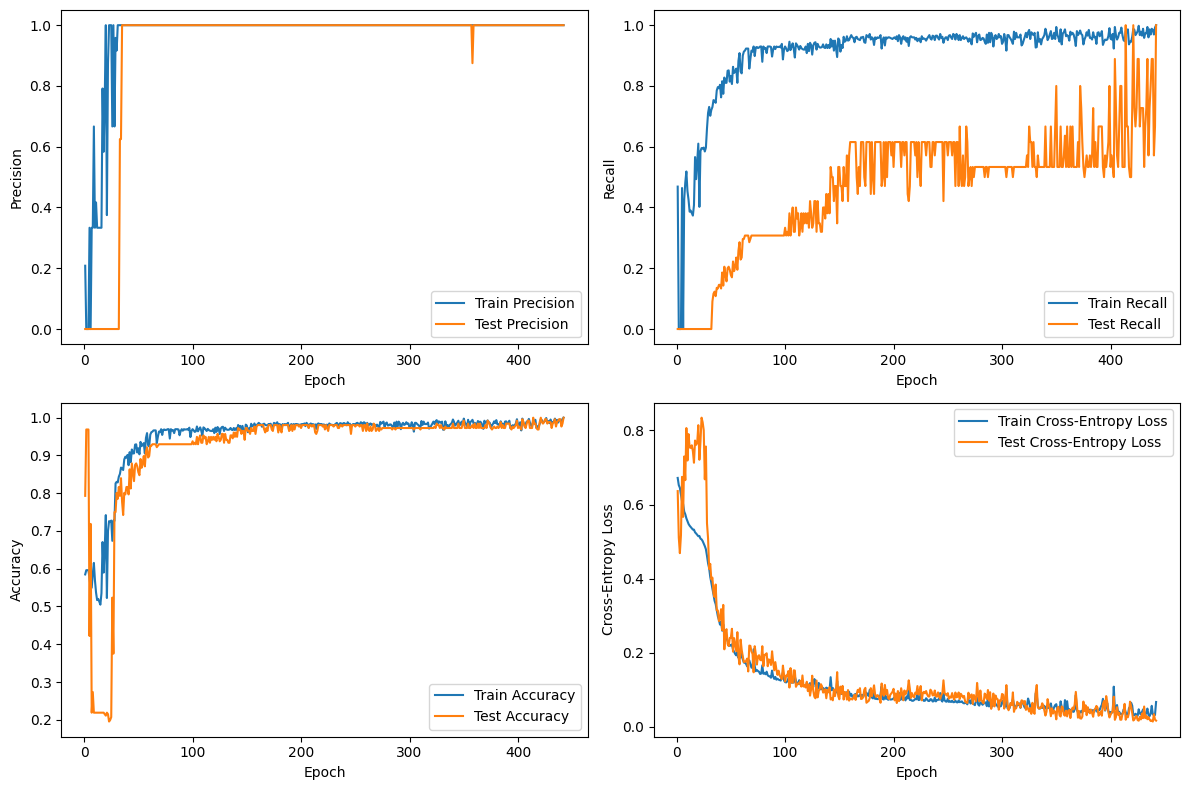

In [ ]:
plot_metrics(result["k=0"]["metric"])

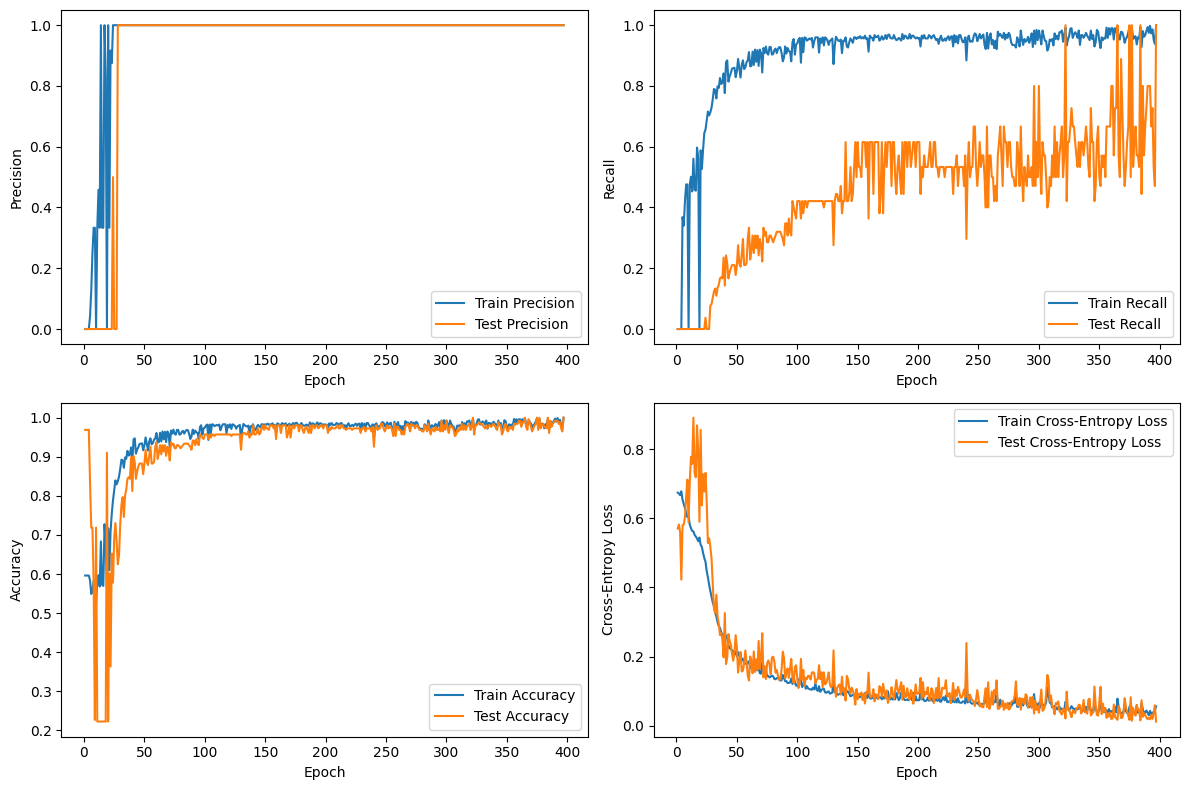

In [ ]:
plot_metrics(result["k=1"]["metric"])

In [2]:
for i in range(4):
  print(f"weights of fold {i}",result[f"k={i}"]["weights"])
  print(f"bias of fold {i}",result[f"k={i}"]["bias"])
  print("\n\n\n")

weights of fold 0 [array([[ 11.2353072 ,  22.70947834,  10.09524053,  -5.6365978 ,
          2.78419739,  -2.71708902,   5.59610134, -10.00481738,
        -22.698939  , -11.37532941],
       [-11.86265826, -23.54016501, -10.17156686,   5.85323479,
         -2.86591298,   2.85300211,  -5.62954261,  10.18816229,
         23.51598711,  11.71037168]]), array([[-24.32310219, -24.35558375]])]
bias of fold 0 [array([[-1.57182573],
       [-1.55465821]]), array([[10.28556386]])]




weights of fold 1 [array([[ 12.06727868, -24.04754728,  -3.05359376,   7.5093195 ,
         -5.9505513 ,   5.97282284,  -7.46679692,   3.06713175,
         23.94892117, -11.94499786],
       [ 11.34083739, -22.70245056,  -2.85059346,   7.15011867,
         -5.68846943,   5.85159444,  -7.0599552 ,   2.98305851,
         22.65603201, -11.36371407]]), array([[ 22.54301888, -24.62556548]])]
bias of fold 1 [array([[ 1.58798839],
       [-1.49029445]]), array([[-11.6736649]])]




weights of fold 2 [array([[-27.51426553,

## Neural network Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
input_neurons = 10
hidden_neurons = 2
output_neurons = 1
weights_input_hidden = np.array([[ -7.22321659, -11.15471068, -30.00484398,  13.08466657,
        -15.0766471 ,  14.81645208, -13.11446119,  29.95009006,
          10.9668077 ,   7.11140227],
        [  7.48857155,  11.20225432,  30.07325613, -13.1441687 ,
          15.08768163, -15.10126949,  13.11893102, -30.1417512 ,
        -11.18918466,  -7.44585737]]).T
biases_hidden = np.array([[1.62426502],
        [1.63230885]]).reshape(-1)
weights_hidden_output = np.array([[23.73266741, 23.84381938]]).T
bias_output = np.array([[-35.80629779]]).reshape(-1)

In [ ]:
def visualize_neural():
  a=input()
  input_values = [int(i) for i in list(a)]
  hidden_layer_input = np.dot(input_values, weights_input_hidden) + biases_hidden
  hidden_layer_output = np.array([round(i,3) for i in sigmoid(hidden_layer_input)])
  output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
  output = sigmoid(output_layer_input)
  G = nx.DiGraph()
  for i in range(input_neurons):
      G.add_node(f'{i}={input_values[i]}', pos=(0, i))
  for i in range(hidden_neurons):
      G.add_node(f'{i},f({np.round(hidden_layer_input[i],3)})={np.round(hidden_layer_output[i],3)}', pos=(1, 0.5*(input_neurons-1-hidden_neurons)+i))
  for i in range(output_neurons):
      G.add_node(f'Output {i+1}={output}', pos=(2, 4))
  for i in range(input_neurons):
      for j in range(hidden_neurons):
          weight = weights_input_hidden[i][j]
          G.add_edge(f'{i}={input_values[i]}', f'{j},f({np.round(hidden_layer_input[j],3)})={np.round(hidden_layer_output[j],3)}', weight=f"W[{j,i}]={weight}")
  for i in range(hidden_neurons):
      for j in range(output_neurons):
          weight = weights_hidden_output[i][j]
          G.add_edge(f'{i},f({np.round(hidden_layer_input[i],3)})={np.round(hidden_layer_output[i],3)}', f'Output {j+1}={output}', weight=weight)
  pos = nx.get_node_attributes(G, 'pos')
  plt.figure(figsize=(10, 5),dpi=200)
  nx.draw(G, pos, with_labels=True, node_size=1e+3, node_color='lightblue', font_size=3, font_weight='bold')
  labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels,font_size=3,label_pos=0.8)
  plt.title('Neural Network Graph')
  plt.show()

1000000000


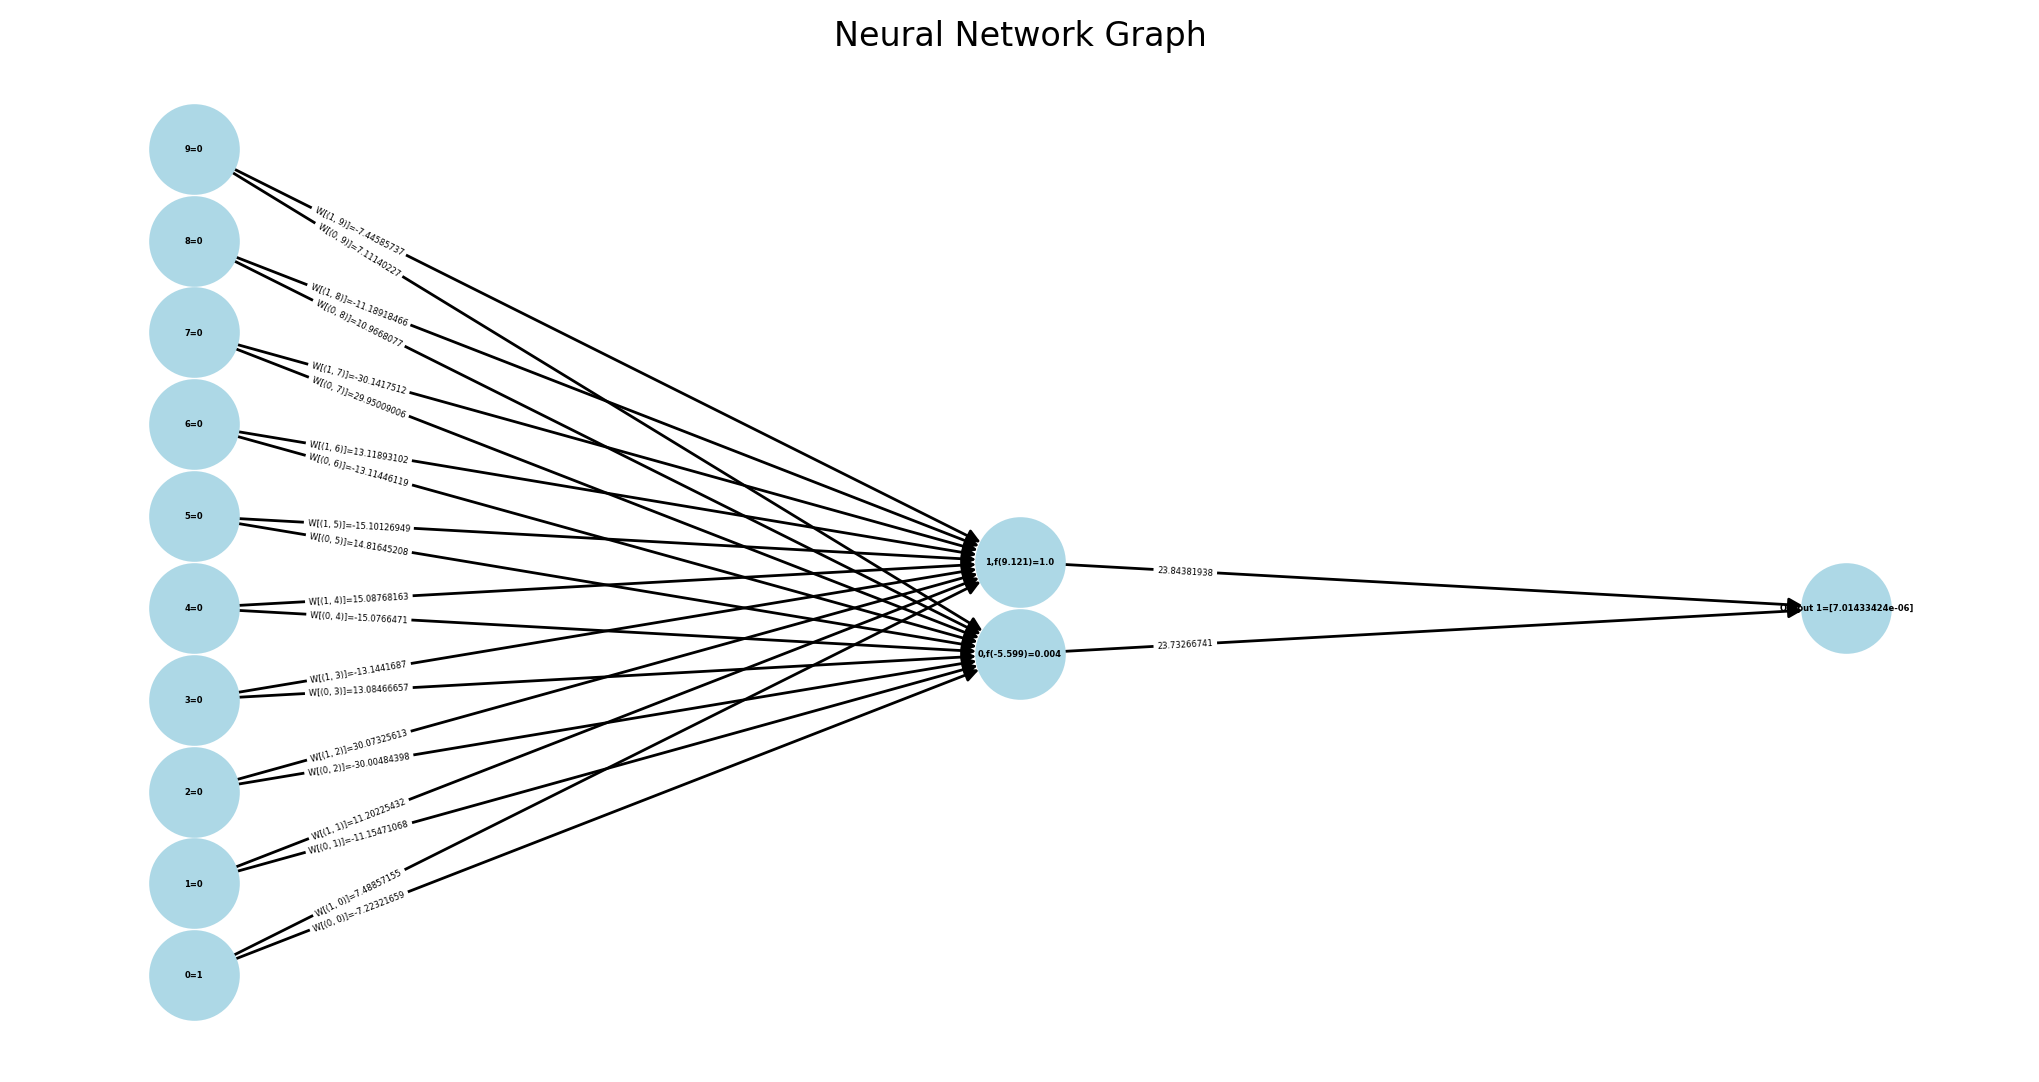

In [ ]:
visualize_neural()

## Cross validation result for each k with associated weight

In [3]:
for i in range(4):
  print(f"weights of fold {i}",result[f"k={i}"]["weights"])
  print(f"bias of fold {i}",result[f"k={i}"]["bias"])
  print("\n\n\n")

weights of fold 0 [array([[ 11.2353072 ,  22.70947834,  10.09524053,  -5.6365978 ,
          2.78419739,  -2.71708902,   5.59610134, -10.00481738,
        -22.698939  , -11.37532941],
       [-11.86265826, -23.54016501, -10.17156686,   5.85323479,
         -2.86591298,   2.85300211,  -5.62954261,  10.18816229,
         23.51598711,  11.71037168]]), array([[-24.32310219, -24.35558375]])]
bias of fold 0 [array([[-1.57182573],
       [-1.55465821]]), array([[10.28556386]])]




weights of fold 1 [array([[ 12.06727868, -24.04754728,  -3.05359376,   7.5093195 ,
         -5.9505513 ,   5.97282284,  -7.46679692,   3.06713175,
         23.94892117, -11.94499786],
       [ 11.34083739, -22.70245056,  -2.85059346,   7.15011867,
         -5.68846943,   5.85159444,  -7.0599552 ,   2.98305851,
         22.65603201, -11.36371407]]), array([[ 22.54301888, -24.62556548]])]
bias of fold 1 [array([[ 1.58798839],
       [-1.49029445]]), array([[-11.6736649]])]




weights of fold 2 [array([[-27.51426553,

In [5]:
w1=[np.array([[ 11.2353072 ,  22.70947834,  10.09524053,  -5.6365978 ,
          2.78419739,  -2.71708902,   5.59610134, -10.00481738,
        -22.698939  , -11.37532941],
       [-11.86265826, -23.54016501, -10.17156686,   5.85323479,
         -2.86591298,   2.85300211,  -5.62954261,  10.18816229,
         23.51598711,  11.71037168]]), np.array([[-24.32310219, -24.35558375]])]
b1=[np.array([[-1.57182573],
       [-1.55465821]]), np.array([[10.28556386]])]
w2=[np.array([[ 12.06727868, -24.04754728,  -3.05359376,   7.5093195 ,
         -5.9505513 ,   5.97282284,  -7.46679692,   3.06713175,
         23.94892117, -11.94499786],
       [ 11.34083739, -22.70245056,  -2.85059346,   7.15011867,
         -5.68846943,   5.85159444,  -7.0599552 ,   2.98305851,
         22.65603201, -11.36371407]]), np.array([[ 22.54301888, -24.62556548]])]
b2=[np.array([[ 1.58798839],
       [-1.49029445]]), np.array([[-11.6736649]])]
w3=[np.array([[-27.51426553, -13.86913712,  -3.41198871, -12.05273353,
          6.84609388,  -6.8438349 ,  12.05433246,   3.43566254,
         13.70276614,  27.44734854],
       [ 26.78253918,  13.3917943 ,   3.31675137,  11.85917246,
         -6.680098  ,   6.62994395, -11.87574641,  -3.34041974,
        -13.43865332, -26.8779921 ]]), np.array([[-28.61811889, -28.59388476]])]
b3=[np.array([[-1.64264697],
       [-1.64342273]]), np.array([[12.84567135]])]
w4=[np.array([[ -7.22321659, -11.15471068, -30.00484398,  13.08466657,
        -15.0766471 ,  14.81645208, -13.11446119,  29.95009006,
          10.9668077 ,   7.11140227],
        [  7.48857155,  11.20225432,  30.07325613, -13.1441687 ,
          15.08768163, -15.10126949,  13.11893102, -30.1417512 ,
        -11.18918466,  -7.44585737]]), np.array([[23.73266741, 23.84381938]])]
b4=[np.array([[1.62426502],
        [1.63230885]]), np.array([[-35.80629779]])]

In [11]:
def sigmoid(z):
    return 1.0/(1.0+ np.exp(-z))

In [12]:
def feedforward(x,bias,weights):
    for b,w in zip(bias,weights):
      x=sigmoid(np.dot(w,x)+b)
    return x

In [13]:
def predict(weights,bias,X_test):
    test_results = [1 if feedforward(x,bias,weights)>0.5 else 0 for x in X_test]
    return np.array(test_results)

In [14]:
def is_palindrome(s):
    s = list(s)
    return s == s[::-1]

def generate_combinations(length):
    if length <= 0:
        return [[]]
    result = [[0], [1]]
    for _ in range(length - 1):
        result = [comb + [0] for comb in result] + [comb + [1] for comb in result]
    return result

list_length = 10
raw_X = np.array(generate_combinations(list_length)).reshape(2**list_length, list_length, 1)
raw_y = np.array([1 if is_palindrome(bit_string[:, 0]) else 0 for bit_string in raw_X])

In [15]:
from sklearn.metrics import classification_report

**Classification report of fold1**

In [16]:
y_pred=predict(w1,b1,raw_X)
target_names = ['class0: Non-palindrom', 'class1: Palindrom']
print(classification_report(raw_y, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

class0: Non-palindrom       1.00      1.00      1.00       992
    class1: Palindrom       1.00      1.00      1.00        32

             accuracy                           1.00      1024
            macro avg       1.00      1.00      1.00      1024
         weighted avg       1.00      1.00      1.00      1024



**Classification report of fold2**

In [17]:
y_pred=predict(w2,b2,raw_X)
target_names = ['class0: Non-palindrom', 'class1: Palindrom']
print(classification_report(raw_y, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

class0: Non-palindrom       1.00      1.00      1.00       992
    class1: Palindrom       1.00      1.00      1.00        32

             accuracy                           1.00      1024
            macro avg       1.00      1.00      1.00      1024
         weighted avg       1.00      1.00      1.00      1024



**Classification report of fold3**

In [18]:
y_pred=predict(w3,b3,raw_X)
target_names = ['class0: Non-palindrom', 'class1: Palindrom']
print(classification_report(raw_y, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

class0: Non-palindrom       1.00      1.00      1.00       992
    class1: Palindrom       1.00      1.00      1.00        32

             accuracy                           1.00      1024
            macro avg       1.00      1.00      1.00      1024
         weighted avg       1.00      1.00      1.00      1024



**Classification report of fold4**

In [19]:
y_pred=predict(w4,b4,raw_X)
target_names = ['class0: Non-palindrom', 'class1: Palindrom']
print(classification_report(raw_y, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

class0: Non-palindrom       1.00      1.00      1.00       992
    class1: Palindrom       1.00      1.00      1.00        32

             accuracy                           1.00      1024
            macro avg       1.00      1.00      1.00      1024
         weighted avg       1.00      1.00      1.00      1024

